# **NUMERICAL COMPUTATIONS FOR THE EXTENDED SIAM**

<hr style="border:4px solid skyblue">

## **HOUSEKEEPING STUFF**
<hr style="border:2px solid skyblue">

In [2]:
#### IMPORTS ####

from tqdm.notebook import tqdm
from math import sqrt
from multiprocessing import Pool
from itertools import product, repeat
from matplotlib import pyplot as plt
from matplotlib import colors, animation
import matplotlib as mpl
import numpy as np
from varname import nameof
from qutip import *
from matplotlib.cm import get_cmap
import colorcet as cc
import subprocess
import os, shutil
from more_itertools import intersperse
import time
from IPython.display import display, clear_output



#### GLOBAL PARAMETERS ####

deltaD = 0.05
rho = 2/deltaD
nj = rho*deltaD
rhoD = lambda D,D0: 1#2 * np.sqrt(1 - D**2 / D0**2) / (np.pi * D0) 


#### PATHS FOR SAVING FIGURES AND RAW #### 
#### DATA LIKE EIGENVALUES/VECTORS    ####

fig_save_path = "./figures/"
spectrum_path_phases = lambda D0,num,J0,J1,r0,r1,VbJ,UbyUb: "./esiam-phases-data/P-{:.5f},{:.0f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f}.npy".format(D0,num,J0,J1,r0,r1,VbJ,UbyUb)
spectrum_path_E = lambda num_sites,t,U,V,J,Ub: "./esiam-spectrum/E-{:.0f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f}".format(num_sites, t, U, V, J, Ub)
spectrum_path_X = lambda num_sites,t,U,V,J,Ub: "./esiam-spectrum/X-{:.0f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f}".format(num_sites, t, U, V, J, Ub)
spectrum_path_E_kspace = lambda num_sites,E,U,V,J,Ub: "./esiam-spectrum/k-E-{:.0f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f}".format(num_sites,E,U,V,J,Ub)
spectrum_path_X_kspace = lambda num_sites,E,U,V,J,Ub: "./esiam-spectrum/k-X-{:.0f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f}".format(num_sites,E,U,V,J,Ub)
spectrum_path_SW1 = lambda num_sites,E,U,V,J,Ub,ops: "./esiam-spectrum/sw1-{:.0f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.1f},{:.1f}".format(num_sites,E,U,V,J,Ub,ops[0],ops[1])
spectrum_path_SW2 = lambda num_sites,E,U,V,J,Ub,ops: "./esiam-spectrum/sw2-{:.0f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.1f},{:.1f}".format(num_sites,E,U,V,J,Ub,ops[0],ops[1])


#### STYLE MODIFICATIONS FOR PLOTTING FIGURES ####

plt.style.use('ggplot')
markers = ["o", "X", "P", "p", "*"]
cols = [p['color'] for p in plt.rcParams['axes.prop_cycle']]
plt.rcParams.update({'font.size': 30,
                     'figure.figsize': (11,7),
                     'axes.facecolor': 'white',
                     'axes.edgecolor': 'lightgray',
                     "figure.autolayout": 'True',
                     'axes.xmargin': 0.03,
                     'axes.ymargin': 0.05,
                     'axes.grid': False,
                     'axes.linewidth': 5,
                     'lines.markersize': 10,
                     'text.usetex': True,
                     'lines.linewidth': 8,
                     "legend.frameon": True,
                     "legend.framealpha": 0.7,
                     "legend.handletextpad": 1,
                     "legend.edgecolor": "gray",
                     "legend.handlelength": 1,
                     "legend.labelspacing": 0,
                     "legend.columnspacing": 1,
                     "legend.fontsize": 35,
                    })
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{braket}\usepackage{nicefrac}')


linestyles = ["-", "--", ":"]
bbox = dict(boxstyle="round", facecolor="white")
plt.plot([], [])
plt.show()
clear_output()

## **DEFINITIONS OF ALL HELPER FUNCTIONS**
<hr style="border:2px solid skyblue">

## **Modules for tracking RG flow**

In [3]:
#### RETURNS THE DENOMINATORS THAT APPEAR IN RG EQUATIONS ####

def den(w, D, U, J, K, Ub=0):
    d0 = w - D/2 + Ub/4 - U/2 + K/4
    d1 = w - D/2 + Ub/4 + U/2 + J/4
    d2 = w - D/2 + Ub/4 + J/4
    d3 = w - D/2 + Ub/4 + K/4
    return np.array([d0, d1, d2, d3])



#### RETURNS THE MODIFIED SET OF COUPLINGS AT A GIVEN RG STEP ####

def rg_flow(w, D, D0, U, V, J, Ub=0):
    theta = lambda x: 1 if x < 0 else 0
    K = 0
    d0,d1,d2,d3 = den(w, D, U, J, K, Ub=Ub)
    deltaU = 4*V**2*nj*(theta(d1)/d1 - theta(d0)/d0) - nj*J**2 * theta(d2)/(2*d2)
    deltaV = -nj*(V/8)*((3*J + 4*Ub)*(theta(d1)/d1 + theta(d2)/d2) + 4*Ub*(theta(d0)/d0 + theta(d3)/d3))
    deltaJ = -nj*(J**2 + 4*J*Ub) * theta(d2)/d2

    U = 0 if (U + deltaU) * U <= 0 else U + deltaU
    V = 0 if (V + deltaV) * V <= 0 else V + deltaV
    J = 0 if (J + deltaJ) * J <= 0 else J + deltaJ

    return U, V, J



#### SAME AS THE PREVIOUS FUNCTION rg_flow(), ####
#### BUT FOR THE J-Ub MODEL ####

def rg_J_Ub(w,D,J,Ub):
    d2 = w - D/2 + Ub/4 + J/4
    deltaJ = -nj*(J**2 + 4*J*Ub) * 1/d2 if d2 < 0 else 0
    J = 0 if (J + deltaJ) * J <= 0 else J + deltaJ
    return J



#### TAKES BARE PARAMETER VALUES AND RETURNS THE COMPLETE RG FLOW ####

def complete_RG(w, D0, U0, V0, J0, Ub=0, stop_on_fp=True):
    signs = np.sign(den(w, D0, U0, J0, 0, Ub=Ub))
    E, U, V, J = [[g0] for g0 in (D0, U0, V0, J0)]
    for D in np.arange(D0, 0, -deltaD):
        w = -D/2
        U_j, V_j, J_j = rg_flow(w, D, D0, U[-1], V[-1], J[-1], Ub=Ub)
        U.append(U_j)
        V.append(V_j)
        J.append(J_j)
        E.append(D - deltaD)
        d0,d1,d2,d3 = den(w, E[-1], U[-1], J[-1], 0, Ub=Ub)
        if True not in np.equal(np.sign((d0, d1, d2, d3)), signs) and stop_on_fp:
            break
        
    return np.array(E), np.array(U), np.array(V), np.array(J)



#### SAME AS THE PREVIOUS FUNCTION complete_RG(), ####
#### BUT FOR THE J-Ub MODEL ####

def complete_RG_J_Ub(w, D0, J0, Ub):
    d2 = w - D0/2 + Ub/4 + J0/4
    assert d2 <= 0
    J = [J0]
    E = [D0]
    for D in np.arange(D0, 0, -deltaD):
        w = -D/2
        J_j = rg_J_Ub(w, D, J[-1], Ub)
        J.append(J_j)
        E.append(D - deltaD)
        d2 = w - E[-1]/2 + Ub/4 + J[-1]/4
        if d2 >= 0:
            break
    return np.array(E), np.array(J)

## **Hamiltonian designing and diagonalisation**

In [4]:
####     TAKES A QUTIP STATE AS INPUT AND RETURNS     ####
####     THE NUMBER OF FOCK STATES AND NUMBER OF      ####
####     LATTICE SITES PRESENT WITHIN THE STATE       ####

def get_state_dim(X):
    total_dim = int(np.log2(X.shape[0]))
    total_num_sites = int(total_dim/2) # total number of sites
    assert total_num_sites == total_dim/2
    return total_dim, total_num_sites



####     (REAL SPACE) CONSTRUCTS A QUTIP HAMILTONIAN       ####
####     FOR THE ESIAM MODEL, GIVEN A SET OF PARAMETERS    ####


def get_ham_rspace(t, lattice_dim, U, V, J, Ubath=0, mu=0, reflect=False):
    total_dim = 2*(1 + lattice_dim)
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    imp = [c_all[0], c_all[1]] if not reflect else [c_all[total_dim - 1], c_all[total_dim - 2]]
    zero = [c_all[2], c_all[3]] if not reflect else [c_all[total_dim - 3], c_all[total_dim - 4]]
    cbath_up = [(c_all[i] if not reflect else c_all[total_dim - 1 - i]) for i in range(2, total_dim, 2)]
    cbath_dn = [(c_all[i] if not reflect else c_all[total_dim - 1 - i]) for i in range(3, total_dim, 2)]
    
    Sz_imp = 0.5 * (imp[0].dag()*imp[0] - imp[1].dag()*imp[1])
    Sp_imp = imp[0].dag() * imp[1]
    Sz_bath = 0.5 * (zero[0].dag()*zero[0] - zero[1].dag() * zero[1])
    Sp_bath = zero[0].dag() * zero[1]
    Sm_imp = Sp_imp.dag()
    Sm_bath = Sp_bath.dag()
    
    H_U = - (U/2) * (2 * Sz_imp)**2
    H_Ubath = - (Ubath/2) * (2*Sz_bath)**2
    H_J = J * (Sz_imp * Sz_bath + 0.5 * Sp_imp * Sm_bath + 0.5 * Sm_imp * Sp_bath)
    H_mu = -mu * sum([c_all[i].dag()*c_all[i] for i in range(total_dim)])
    
    H_V = V * (imp[0].dag() * zero[0] + imp[1].dag() * zero[1])
    H_V += H_V.dag()

    H_t = 0 * H_Ubath
    for i,_ in enumerate(cbath_up[:-1]):
        H_t += cbath_up[i].dag() * cbath_up[i+1] + cbath_dn[i].dag() * cbath_dn[i+1]
    H_t += H_t.dag()

    return H_U + H_J + H_V + H_t + H_Ubath + H_mu



####     (MOM. SPACE) CONSTRUCTS A QUTIP HAMILTONIAN       ####
####     FOR THE ESIAM MODEL, GIVEN A SET OF PARAMETERS    ####


def get_ham_kspace(Ek_0, ed, U, V, J, Ubath=0, ignore=0): 
    assert ed == -U/2
    dim = len(Ek_0)
    total_dim = 2 * (dim + 1)
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    Sz_imp = 0.5 * (c_all[0].dag()*c_all[0] - c_all[1].dag()*c_all[1])
    Sp_imp = c_all[0].dag()*c_all[1]
    Sm_imp = Sp_imp.dag()
    c0_up = sum([c_all[i] for i in range(2, total_dim-1-ignore, 2)])
    c0_dn = sum([c_all[i+1] for i in range(2, total_dim-1-ignore, 2)])
    S0_z = 0.5 * (c0_up.dag()*c0_up - c0_dn.dag()*c0_dn)
    S0_plus = c0_up.dag() * c0_dn
    S0_minus = S0_plus.dag()
    H_J = J * (Sz_imp * S0_z + 0.5 * (Sp_imp * S0_minus + Sm_imp * S0_plus))
    H_U = (-U*2) * Sz_imp**2
    H_Ubath = - 0.5 * Ubath * (2*S0_z)**2 
    H_K = sum([Ek_0[i-1]*(c_all[2*i].dag()*c_all[2*i] + c_all[2*i+1].dag()*c_all[2*i+1]) for i in range(1, dim+1)])
    H_V = V * (c_all[0].dag() * c0_up + c_all[1].dag() * c0_dn)

    return H_U + H_Ubath + H_K + H_V + H_V.dag() + H_J

## **Computation of various quantifiers (overlaps,correlation functions, entanglement, etc) in states**

In [5]:
def get_all_confs(total_dim):
    return [str(bin(num))[2:].zfill(total_dim) for num in range(2**total_dim)]


####     GIVEN A STATE/SET OF STATES, COMPUTES            ####
####     THE AVERAGE QFI IN THE STATE, CORRESPONDING      ####
####     TO SOME PREDEFINED OPERATORS                     ####

def get_QFI(Xgs):
    if not isinstance(Xgs, list):
        Xgs = [Xgs]
        
    total_dim, total_num_sites = get_state_dim(Xgs[0])
    
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    Sz_all = [0.5 * (c_all[2*i].dag()*c_all[2*i] - c_all[2*i + 1].dag()*c_all[2*i + 1]) for i in range(total_num_sites)]
    Cz_all = [0.5 * (c_all[2*i].dag()*c_all[2*i] + c_all[2*i + 1].dag()*c_all[2*i + 1] - 1) for i in range(total_num_sites)]
    Sp_all = [c_all[2*i].dag() * c_all[2*i + 1] for i in range(total_num_sites)]
    Cp_all = [c_all[2*i].dag() * c_all[2*i + 1].dag() for i in range(total_num_sites)]

    SpSm = Sp_all[0] * Sp_all[1].dag() + Sp_all[1] * Sp_all[0].dag()
    Sdz = Sz_all[0]
    CpCm_01 = Cp_all[1] * Cp_all[2].dag() + Cp_all[2] * Cp_all[1].dag()
    
    QFI_labels = ("spin-flip", "charge", "spin-d")
    QFI_dict = {}
    for label,op in zip(QFI_labels, (SpSm, CpCm_01, Sdz)):
        assert op == op.dag()
        QFI_dict[label] = sum([4*np.real(np.array(X.dag() * op**2 * X)[0][0]) 
                               - 4*np.real(np.array(X.dag() * op * X)[0][0])**2
                               for X in Xgs])/len(Xgs)
    return QFI_dict



####     GIVEN A STATE/SET OF STATES AND A PAIR OF POSITIONS,    ####
####     COMPUTES THE AVERAGE MUTUAL INFORMATION BETWEEN         ####
####     SITES AT THE PROVIDED POSITIONS                         ####

def get_MI(Xgs, i, j):
    if not isinstance(Xgs, list):
        Xgs = [Xgs]
    
    mut_info = 0
    for X in Xgs:
        rho = X * X.dag()
        rho_part = rho.ptrace(i+j)
        mut_info += entropy_mutual(rho_part, list(range(len(i))), list(range(len(i), len(i)+len(j))))/len(Xgs)
    return mut_info


####     GIVEN A STATE/SET OF STATES AND A POSITIONS,      ####
####     COMPUTES THE AVERAGE ENTANGL. ENTROPY             ####
####     AT THE PROVIDED LATTICE SITE                      ####

def get_EE(Xgs, i):
    if not isinstance(Xgs, list):
        Xgs = [Xgs]
    ent_entr = 0
    for X in Xgs:
        rho = X * X.dag()
        rho_part = rho.ptrace((2*i, 2*i+1))
        ent_entr += entropy_vn(rho_part) / len(Xgs)
    return ent_entr



#### COMPUTES THE CORRELATION c^dag_i c_j c^dag_k c_l,    ####
#### GIVEN A STATE AND A SET OF INDICES i,j,k,l           ####

def get_2particle_corr(Xgs, guys):
    i,j,k,l = guys  
    if isinstance(Xgs, list):
        total_dim, _ = get_state_dim(Xgs[0])
        c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
        two_p_corr = sum([(X.dag() * c_all[i].dag() * c_all[j] * c_all[k].dag() * c_all[l] * X)[0][0][0] for X in Xgs]) / len(Xgs)
    else:
        total_dim, _ = get_state_dim(Xgs)
        c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
        two_p_corr = (Xgs.dag() * c_all[i].dag() * c_all[j] * c_all[k].dag() * c_all[l] * Xgs)[0][0][0]
    return two_p_corr



#### COMPUTES THE SPIN-FLIP CORRELATION IN A GIVEN    ####
#### STATE BETWEEN THE PROVIDED PAIR OF INDICES       ####

def get_spin_flip_corr(Xgs, pair):
    (i, j) = pair    
    guys_plus_minus = (2*i, 2*i+1, 2*j+1, 2*j)
    guys_minus_plus = (2*i+1, 2*i, 2*j, 2*j+1)

    return 0.5 * (get_2particle_corr(Xgs, guys_plus_minus) + get_2particle_corr(Xgs, guys_minus_plus))



#### COMPUTES THE DENSITY-DENSITY CORRELATION       ####
#### IN THE UP-UP OR DOWN-DOWN STATE, IN THE        ####
#### PROVIDED PAIR OF INDICES                       ####

def get_density_ferro_corr(Xgs, pair, spin):
    (i, j) = pair
    if not isinstance(Xgs, list):
        Xgs = [Xgs]
    guys = (2*i, 2*i, 2*j, 2*j) if spin == 1 else (2*i+1, 2*i+1, 2*j+1, 2*j+1)
    return get_2particle_corr(Xgs, guys)
    
    

#### COMPUTES THE DENSITY-DENSITY CORRELATION               ####
#### IN THE UP-DOWN STATE, IN THE PROVIDED PAIR OF INDICES     ####

def get_density_antiferro_corr(Xgs, pair, spin):
    (i, j) = pair
    if not isinstance(Xgs, list):
        Xgs = [Xgs] 
    guys = (2*i, 2*i, 2*j+1, 2*j+1) if spin == 1 else (2*i+1, 2*i+1, 2*j, 2*j)
    return get_2particle_corr(Xgs, guys)
    
    

#### COMPUTES THE ISING CORRELATION           ####
#### BETWEEN THE PROVIDED PAIR OF INDICES     ####

def get_spin_ising_corr(Xgs, pair):
    (i, j) = pair
    if not isinstance(Xgs, list):
        Xgs = [Xgs] 
    return 0.25*(get_density_ferro_corr(Xgs, (i,j), 1) + get_density_ferro_corr(Xgs, (i,j), -1) 
                 - get_density_antiferro_corr(Xgs, (i,j), 1) - get_density_antiferro_corr(Xgs, (i,j), -1))



#### COMPUTES THE ISING CORRELATION           ####
#### BETWEEN THE PROVIDED PAIR OF INDICES     ####

def get_charge_flip_corr(Xgs, pair):
    (i, j) = pair
    if not isinstance(Xgs, list):
        Xgs = [Xgs]  
    guys_plus_minus = (2*i, 2*j, 2*i+1, 2*j+1)
    guys_minus_plus = (2*j, 2*i, 2*j+1, 2*i+1)
    return 0.5 * (get_2particle_corr(Xgs, guys_plus_minus) + get_2particle_corr(Xgs, guys_minus_plus))



#### COMPUTES THE CHARGE ISING CORRELATION    ####
#### BETWEEN THE PROVIDED PAIR OF INDICES     ####

def get_charge_ising_corr(Xgs, pair):
    (i, j) = pair
    if not isinstance(Xgs, list):
        Xgs = [Xgs] 
    return (0.25 * (get_density_ferro_corr(Xgs, (i,j), 1) + get_density_ferro_corr(Xgs, (i,j), -1)
                    + get_density_antiferro_corr(Xgs, (i,j), 1) + get_density_antiferro_corr(Xgs, (i,j), -1)
                    - get_density_ferro_corr(Xgs, (i,i), 1) - get_density_ferro_corr(Xgs, (i,i), -1)
                    - get_density_ferro_corr(Xgs, (j,j), 1) - get_density_ferro_corr(Xgs, (j,j), -1) + 1))




#### COMPUTES THE SPIN-SPIN CORRELATION  S_i . S_j    ####
#### BETWEEN THE PROVIDED PAIR OF INDICES i,j         ####
    
def get_spin_spin_corr(Xgs, pair):
    (i, j) = pair  
    if not isinstance(Xgs, list):
        Xgs = [Xgs]
    return get_spin_ising_corr(Xgs, (i, j)) + get_spin_flip_corr(Xgs, (i, j))




#### COMPUTES THE CHARGE-CHARGE CORRELATION  C_i . C_j    ####
#### BETWEEN THE PROVIDED PAIR OF INDICES i,j         ####
    
def get_charge_charge_corr(Xgs, pair):
    (i, j) = pair
    if not isinstance(Xgs, list):
        Xgs = [Xgs]
    return get_charge_ising_corr(Xgs, (i, j)) + get_charge_flip_corr(Xgs, (i, j))




#### COMPUTES THE ONE-PARTICLE CORRELATION  c^dag_i c_j    ####
#### BETWEEN THE PROVIDED PAIR OF INDICES i,j              ####
    
def get_1p(Xgs, guys):
    i, j = guys
    if not isinstance(Xgs, list):
        Xgs = [Xgs]
    total_dim, _ = get_state_dim(Xgs[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    one_p_corr = sum([np.real(np.array(X.dag() * c_all[2*i].dag() * c_all[2*j] * X)[0][0]) for X in Xgs]) / len(Xgs)
    return one_p_corr



####    RETURNS OVERLAP OF GIVEN STATE       ####
####    WITH THE SPIN SINGLET STATE          ####

def get_singlet_overlap(Xgs):
    if not isinstance(Xgs, list):
        Xgs = [Xgs]
    total_dim, total_num_sites = get_state_dim(Xgs[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    S_z = [0.5 * (c_all[i].dag() * c_all[i] - c_all[i+1].dag() * c_all[i+1]) for i in (0, 2)]
    S_plus = sum([c_all[i].dag() * c_all[i+1] for i in (0, 2)])
    S_tot_sq = 0.25 * (S_plus + S_plus.dag())**2 - 0.25 * (S_plus - S_plus.dag())**2 + sum(S_z)**2
    C_z = sum([0.5 * (c_all[i].dag() * c_all[i] + c_all[i+1].dag() * c_all[i+1] - 1) for i in (0, 2)])
    C_plus = sum([c_all[i].dag() * c_all[i+1].dag() for i in (0, 2)])
    C_tot_sq = 0.25 * (C_plus + C_plus.dag())**2 - 0.25 * (C_plus - C_plus.dag())**2 + C_z**2
    singlet_overlap = sum([4 * abs((X.dag() * S_z[0] * S_z[1] * X)[0][0][0]) for X in Xgs])/len(Xgs)
    return singlet_overlap




####    RETURNS OVERLAP OF GIVEN STATE       ####
####    WITH THE CHARGE TRIPLET-ZERO STATE   ####

def get_charge_triplet_overlap(Xgs):
    if not isinstance(Xgs, list):
        Xgs = [Xgs]
    total_dim, total_num_sites = get_state_dim(Xgs[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    C_z = [0.5 * (c_all[i].dag() * c_all[i] + c_all[i+1].dag() * c_all[i+1] - 1) for i in (0, 2)]
    C_plus = sum([c_all[i].dag() * c_all[i+1].dag() for i in (0, 2)])
    C_tot_sq = 0.25 * (C_plus + C_plus.dag())**2 - 0.25 * (C_plus - C_plus.dag())**2 + sum(C_z)**2
    charge_triplet_overlap = sum([4 * abs((X.dag() * C_z[0] * C_z[1] * X)[0][0][0]) for X in Xgs])/len(Xgs)
    return charge_triplet_overlap




####    RETURNS OVERLAP OF GIVEN STATE       ####
####    WITH THE LOCAL MOMENT STATE         ####

def get_loc_mom_overlap(Xgs):
    if not isinstance(Xgs, list):
        Xgs = [Xgs]
    total_dim, total_num_sites = get_state_dim(Xgs[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    S_dz = 0.5 * (c_all[0].dag() * c_all[0] - c_all[1].dag() * c_all[1])
    C_0z = 0.5 * (c_all[2].dag() * c_all[2] + c_all[3].dag() * c_all[3] - 1)
    loc_mom_overlap = sum([2 * abs((X.dag() * S_dz * X)[0][0][0]) for X in Xgs])/len(Xgs)
    return loc_mom_overlap



def get_reduced_psi(Xgs, site, spin):
    assert spin in ["u", "d"]
    if not isinstance(Xgs, list):
        Xgs = [Xgs]
    total_dim, total_num_sites = get_state_dim(Xgs[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    c_all_reduced = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i - 2)) for i in range(total_dim-1)]
    all_confs = get_all_confs(total_dim-1)
    tracing_indices = [2 * site_i + (0 if spin == "u" else 1) for site_i in site]
    reduced_psi = [[0, 0], [0, 0], [0, 0]]
    for config_string in all_confs:
        for j,tracing_index in enumerate(tracing_indices):
            for occupancy in [0, 1]:
                bra_state = (c_all[tracing_index].dag() if occupancy == 1 else 1) * tensor([basis(2,0)]*total_dim)
                bra_state_reduced = tensor([basis(2,0)]*(total_dim - 1))
                for i in range(total_dim - 1):
                    operator = tensor([identity(2)] * total_dim) if config_string[i] == '0' else c_all[i if i < tracing_index else i + 1].dag()
                    operator_reduced = tensor([identity(2)] * (total_dim-1)) if config_string[i] == '0' else c_all_reduced[i].dag()
                    bra_state = operator * bra_state
                    bra_state_reduced = operator_reduced * bra_state_reduced

                config_weight = (bra_state.dag() * Xgs)[0][0][0][0]
                reduced_psi[j][occupancy] += config_weight * bra_state_reduced
    return reduced_psi


def get_kspace_correlation(corrs, momentum_sets, coord_num, loc_mom_factor, disperson_near_arr, disperson_next_near_arr, subtract_background=0):
    # print (len(corrs))
    corrs_dd, corrs_d0, corrs_d1, corrs_00, corrs_01 = corrs
    background = (3/4) * subtract_background
    corr_kspace = []
    for i,_ in enumerate(momentum_sets):
        if loc_mom_factor:
            corr_kspace.append(
                0 * 0.5 * (corrs_dd - background + corrs_00 / coord_num)
                + 0.5 * disperson_near_arr[i] * (corrs_d0 + corrs_01) / coord_num
                + disperson_next_near_arr[i] * corrs_d1 / coord_num
                )
        else:
            corr_kspace.append(np.ones_like(disperson_near_arr[i]) * (corrs_dd - background))
    return corr_kspace



####    RETURNS A HOST OF MANY-PARTICLE CORRELATIONS             ####
####    COMPUTED IN THE GROUND STATE OF THE FIXED POINT          ####
####    HAMILTONIAN CORRESPONDING TO THE GIVEN BARE COUPLINGS    ####

def get_gstate_correlations(args):
    Ub,non_inter_args,computables = args
    w,D0,V0,J0,U_by_Ub = non_inter_args["couplings"]
    t, num_sites, momentum_sets = non_inter_args["sys_params"]
    dimension = len(momentum_sets[0])
    U0 = - U_by_Ub * Ub
    if U0 == 0 and V0 == 0 and J0 > 0:
        E, J = complete_RG_J_Ub(w, D0, J0, Ub)
        j = J[-1] if J[-1] > J0 else 0
        u,v = (0,0)
    else:
        E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=Ub)
        u,v,j = [a[-1] for a in (U,V,J)]
        if v + j == 0: u = U0
    ham = get_ham_rspace(t, num_sites, u, v, j, Ubath=Ub)
    try:
        E = qload(spectrum_path_E(num_sites,t,u,v,j,Ub))
        X = qload(spectrum_path_X(num_sites,t,u,v,j,Ub))
    except:
        E, X = ham.eigenstates()
        qsave(E, spectrum_path_E(num_sites,t,u,v,j,Ub))
        qsave(X, spectrum_path_X(num_sites,t,u,v,j,Ub))
        
    Xgs = [Xi for Ei,Xi in zip(E,X) if Ei == min(E)]
    results = {}
    loc_mom_factor = 1 if -Ub / J0 <= 0.25 else 0
    coord_num = 2 * dimension
    if dimension == 2:
        xi_k = [2 * sum(np.cos(momentum_set)) for momentum_set in momentum_sets]
        Xi_k = [2 * np.cos(kx + ky) + 2 * np.cos(kx - ky) for kx, ky in momentum_sets]
    
    if "V_c1" in computables:
        results["V_c1"] = v/V0
    if "SS_weight" in computables:
        singlet_overlap = get_singlet_overlap(Xgs)
        results["SS_weight"] = np.abs(singlet_overlap)
    if "CT_weight" in computables:
        charge_triplet_overlap = get_charge_triplet_overlap(Xgs)
        results["CT_weight"] = np.abs(charge_triplet_overlap)
    if "LM_weight" in computables:
        loc_mom_overlap = get_loc_mom_overlap(Xgs)
        results["LM_weight"] = np.abs(loc_mom_overlap)
    if "geo_ent_ss" in computables:
        xi_SS = 1 - singlet_overlap**2
        results["geo_ent_ss"] = xi_SS
    if "geo_ent_ct" in computables:
        xi_CT = 1 - charge_triplet_overlap**2
        results["geo_ent_ct"] = xi_CT
    if "QFI_spinflip" in computables:
        QFI = get_QFI(Xgs)
        results["QFI_spinflip"] = QFI["spin-flip"]
    if "QFI_charge" in computables:
        QFI = get_QFI(Xgs)
        results["QFI_charge"] = QFI["charge"]
    if "QFI_Sdz" in computables:
        QFI = get_QFI(Xgs)
        results["QFI_Sdz"] = QFI["spin-d"]
    if "spinflip_corr_di" in computables:
        spin_flip_corr_di = [get_spin_flip_corr(Xgs, (0,i)) for i in range(0, num_sites+1)]
        results["spinflip_corr_di"] = spin_flip_corr_di
    if "chargeflip_corr_0i" in computables:
        charge_flip_corr_0i = [get_charge_flip_corr(Xgs, (1,i)) for i in range(1,num_sites+1)]
        results["chargeflip_corr_0i"] = charge_flip_corr_0i
    if "chargeflip_corr_di" in computables:
        charge_flip_corr_di = [get_charge_flip_corr(Xgs, (0,i)) for i in range(0, num_sites+1)]
        results["chargeflip_corr_di"] = charge_flip_corr_di
    if "mutinfo_0i" in computables:
        I_0i = [get_MI(Xgs,[2,3],[2*i,2*i+1]) for i in range(2,num_sites+1)]
        results["mutinfo_0i"] = I_0i
    if "mutinfo_di" in computables:
        I_di = [get_MI(Xgs,[0,1],[i, i+1]) for i in range(2,2*num_sites+1,2)]
        results["mutinfo_di"] = I_di
    if "mutinfo_d_01" in computables:
        I_d_01 = get_MI(Xgs,[0,1],[2,3,4,5])
        results["mutinfo_d_01"] = I_d_01
    if "tripinfo_d01" in computables:
        I_di = [get_MI(Xgs,[0,1],[i, i+1]) for i in range(2,2*num_sites+1,2)]
        I_0i = [get_MI(Xgs,[2,3],[2*i,2*i+1]) for i in range(2,num_sites+1)]
        I_d_01 = get_MI(Xgs,[0,1],[2,3,4,5])
        results["tripinfo_d01"] = I_di[0] + I_di[1] - I_d_01
    if "S_EE" in computables:
        S_EE = get_EE(Xgs, (0))
        results["S_EE"] = S_EE
    if "doub_occ" in computables:
        doub_occ = [get_density_antiferro_corr(Xgs, (i,i), 1) for i in range(num_sites+1)]
        results["doub_occ"] = doub_occ
    if "spin_ising_corr_di" in computables:
        spin_ising_corr_di = [get_spin_ising_corr(Xgs, (0, j)) for j in range(0,num_sites+1)]
        results["spin_ising_corr_di"] = spin_ising_corr_di
    if "spin_spin_corr_di" in computables:
        spin_spin_corr_di = [get_spin_spin_corr(Xgs, (0, j)) for j in range(0,num_sites+1)]
        results["spin_spin_corr_di"] = spin_spin_corr_di
    if "charge_ising_corr_0i" in computables:
        charge_ising_corr_0i = [get_charge_ising_corr(Xgs, (1,i)) for i in range(1, num_sites+1)]
        results["charge_ising_corr_0i"] = charge_ising_corr_0i
    if "charge_charge_corr_0i" in computables:
        charge_charge_corr_0i = [get_charge_charge_corr(Xgs, (1,i)) for i in range(1,num_sites+1)]
        results["charge_charge_corr_0i"] = charge_charge_corr_0i
    if "density_corr_00" in computables:
        density_corr_00 = get_density_antiferro_corr(Xgs, (1,1), 1)
        results["density_corr_00"] = density_corr_00
    if "spin_spin_kspace" in computables:
        corrs = [get_spin_spin_corr(Xgs, (i,j)) for i,j in product(range(3), repeat=2) if i <= j and i < 2]
        spin_spin_kspace = get_kspace_correlation(corrs, momentum_sets, coord_num, loc_mom_factor, xi_k, Xi_k, subtract_background=1)
        results["spin_spin_kspace"] = spin_spin_kspace
    if "charge_charge_kspace" in computables:
        corrs = [get_charge_charge_corr(Xgs, (i,j)) for i,j in product(range(3), repeat=2) if i <= j and i < 2]
        charge_charge_kspace = get_kspace_correlation(corrs, momentum_sets, coord_num, loc_mom_factor, xi_k, Xi_k)
        results["charge_charge_kspace"] = charge_charge_kspace
    if "charge_flip_kspace" in computables:
        corrs = [get_charge_flip_corr(Xgs, (i,j)) for i,j in product(range(3), repeat=2) if i <= j and i < 2]
        charge_flip_kspace = get_kspace_correlation(corrs, momentum_sets, coord_num, loc_mom_factor, xi_k, Xi_k)
        results["charge_flip_kspace"] = charge_flip_kspace
    return results

    
def get_kspace_entanglement_per_val(args):
    (Ub, kx, ky), (w, D0, V0, J0, U_by_Ub, t, num_sites, k2_factor) = args
    dataDirName = "./kspaceEntanglementData/"
    os.makedirs(dataDirName, exist_ok=True)
    dataSavename = dataDirName + "{:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f}.npy".format(Ub, kx, ky, w, D0, V0, J0, U_by_Ub, t, num_sites, k2_factor)
    try:
        entropy_vn, mutual_info = np.load(dataSavename)
    except:
        U0 = - U_by_Ub * Ub
        loc_mom_factor = 1 if -Ub / J0 <= 0.25 else 0
        coord_num = 4
        if U0 == 0 and V0 == 0 and J0 > 0:
            E, J = complete_RG_J_Ub(w, D0, J0, Ub)
            j = J[-1] if J[-1] > J0 else 0
            u,v = (0,0)
        else:
            E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=Ub)
            u,v,j = [a[-1] for a in (U,V,J)]
            if v + j == 0: u = U0
        ham = get_ham_rspace(t, num_sites, u, v, j, Ubath=Ub)
        try:
            E = qload(spectrum_path_E(num_sites,t,u,v,j,Ub))
            X = qload(spectrum_path_X(num_sites,t,u,v,j,Ub))
        except:
            E, X = ham.eigenstates()
            qsave(E, spectrum_path_E(num_sites,t,u,v,j,Ub))
            qsave(X, spectrum_path_X(num_sites,t,u,v,j,Ub))
            
        Xgs = X[0]
        rho = Xgs * Xgs.dag()
        total_dim, _ = get_state_dim(Xgs)
        loc_part, semi_nloc_part, nloc_part = get_traced_rho_parts(rho, total_dim, coord_num, loc_mom_factor)
        args_per_val = [kx, ky, [loc_part, semi_nloc_part, nloc_part], [coord_num, total_dim, k2_factor, loc_mom_factor]]
        entropy_vn, mutual_info = get_mutinfo_k(args_per_val)
        np.save(dataSavename, [entropy_vn, mutual_info])
    return entropy_vn, mutual_info
    

def get_SEE_k(args):
    kx, ky, [loc_part, semi_nloc_part, nloc_part], coord_num = args
    xi_k = 2 * (np.cos(kx) + np.cos(ky))
    rho_k = loc_part + semi_nloc_part * xi_k / np.sqrt(coord_num) + nloc_part * xi_k**2 / coord_num
    rho_k = rho_k / rho_k.tr()
    return rho_k, entropy_vn(rho_k)

def get_mutinfo_k(args):
    kx, ky, [loc_part, semi_nloc_part, nloc_part], [coord_num, total_dim, k2_factor, loc_mom_factor] = args
    args_k = [kx, ky, [loc_part, semi_nloc_part, nloc_part], coord_num]
    rho_k, SEE_k = get_SEE_k(args_k)
    args_k2 = [k2_factor * kx, k2_factor * ky, [loc_part, semi_nloc_part, nloc_part], coord_num]
    rho_k2, SEE_k2 = get_SEE_k(args_k2)
    args_union = [k2_factor * kx, k2_factor * ky, get_traced_rho_parts(rho_k, total_dim, coord_num, loc_mom_factor), coord_num]
    _, SEE_union  = get_SEE_k(args_union)
    mutual_info = SEE_k + SEE_k2 - SEE_union
    return SEE_k, mutual_info



def get_traced_rho_parts(rho, total_dim, coord_num, loc_mom_factor):
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    num_imp = c_all[0].dag() * c_all[0]
    num_zero = c_all[2].dag() * c_all[2]
    hop = c_all[0].dag() * c_all[2] + c_all[2].dag() * c_all[0]
    hop_hole = c_all[2] * c_all[0].dag()  + c_all[0] * c_all[2].dag()
    loc_part = (num_imp * rho * num_imp 
                + num_zero * rho * num_zero * loc_mom_factor
                + num_imp * rho * num_zero * loc_mom_factor
                + num_zero * rho * num_imp * loc_mom_factor
                + (1 - num_imp) * rho * (1 - num_imp)
                + (1 - num_zero) * rho * (1 - num_zero) * loc_mom_factor
                + (1 - num_imp) * rho * (1 - num_zero) * loc_mom_factor
                + (1 - num_zero) * rho * (1 - num_imp) * loc_mom_factor
               )
    semi_nloc_part = (num_imp * rho * hop 
                      + num_zero * rho * hop 
                      + hop * rho * num_imp 
                      + hop * rho * num_zero
                      + (1 - num_imp) * rho * hop_hole 
                      + (1 - num_zero) * rho * hop_hole 
                      + hop_hole * rho * (1 - num_imp) 
                      + hop_hole * rho * (1 - num_zero)
                     ) * loc_mom_factor
    nloc_part = (hop * rho * hop
                 + hop_hole * rho * hop_hole
                ) * loc_mom_factor
    return loc_part, semi_nloc_part, nloc_part

## **Helper modules for computing spectral function**

In [6]:
####    GIVEN SET OF PARAMS, RETURNS THE EIGENVALUES     ####
####    AND EIGENVECTORS OF A MODEL HAMILTONIAN, FOR     ####
####    SPECTRAL FUNCTION CALCULATIONS                   ####

def get_spectrum_kspace(num_sites,U,V,J,Ub,omega):
    
    try:
        E = qload(spectrum_path_E_kspace(num_sites,omega,U,V,J,Ub))
        X = qload(spectrum_path_X_kspace(num_sites,omega,U,V,J,Ub))
    except:
        Ek = np.array([omega, -omega] * int(num_sites/2))
        ed = -U/2
        H = get_ham_kspace(Ek, ed, U, V, J, Ubath=Ub)
        E, X = H.eigenstates()
        qsave(E, spectrum_path_E_kspace(num_sites,omega,U,V,J,Ub))
        qsave(X, spectrum_path_X_kspace(num_sites,omega,U,V,J,Ub))

    E = np.round(E, 5)
    return E,X,len(X[E == min(E)])



####    CALCULATES THE BROADENING THAT WILL LEAD TO THE CORRECT    ####
####    HEIGHT FOR THE SPECTRAL FUNCTION, AS PER THE FS RULE       ####

def find_FDS_broadening(rg_data, U0, J0, Ubath, num_points, target_height, lattice_num, broad_init, eta_delta, ops):
    omega_arr, U_arr, V_arr, J_arr, delta = rg_data
    broad = broad_init
    omega_arr, spec_func_norm = get_spec_func_norm(
                rg_data, U0, J0, Ubath, broad, num_points, lattice_num, eta_delta, ops, hide_tqdm=True)
    height_diff = target_height - max(spec_func_norm[int(len(spec_func_norm)/2)-1:int(len(spec_func_norm)/2) + 2])
    height_diff_tolerance = 1e-3
    if abs(height_diff)/target_height < height_diff_tolerance:
        return broad
    broad_delta = - np.sign(height_diff) * broad_init/4
    with tqdm(total=0) as pbar:
        while abs(broad_delta) > 1e-7:
            pbar.update(1)
            pbar.set_description("U={:.2f},broad={:.5f},inc={:.5f},distance={:.2f}%".format(U0,broad,broad_delta,100*abs(height_diff)/target_height))
            omega_arr, spec_func_norm = get_spec_func_norm(
                rg_data, U0, J0, Ubath, broad, num_points, lattice_num, eta_delta, ops, hide_tqdm=True)
            height_diff = target_height - max(spec_func_norm[int(len(spec_func_norm)/2)-1:int(len(spec_func_norm)/2)+2])
            if abs(height_diff)/target_height < height_diff_tolerance:
                break
            if height_diff * broad_delta > 0 or broad + broad_delta <= 0:
                broad -= broad_delta
                broad_delta /= 10
            else:
                broad += broad_delta
    if abs(height_diff)/target_height >= height_diff_tolerance:
        broad = -1
    print ("Broadening =", broad)
    return broad




####    GIVEN THE ENTIRE RG FLOW, THIS JOINS THE SPECTRAL FUNCTION    ####
####    FROM EACH RG STEP TO OBTAIN THE FULL SPECTRAL FUNCTION        ####

def get_spec_func_norm(rg_data, U0, J0, Ubath, broad, num_points, lattice_num, eta_delta, ops, hide_tqdm=False):
    omega_arr_half, U_arr, V_arr, J_arr, delta = rg_data
    omega_arr = np.unique(np.append(np.flip(-omega_arr_half), omega_arr_half))
    num_iterations = len(omega_arr_half)
    args = zip([omega_arr]*num_iterations, omega_arr_half, U_arr, V_arr, J_arr, [U0]*num_iterations,
               [J0]*num_iterations, [Ubath]*num_iterations, [broad]*num_iterations,
               [lattice_num]*num_iterations, [eta_delta]*num_iterations, [ops]*num_iterations, [delta]*num_iterations)
    spec_func_unnorm = sum(list(tqdm(Pool().imap(spec_func_per_rg_step, args), total=num_iterations, disable=hide_tqdm)))
    spec_func_norm = spec_func_unnorm/np.trapz(spec_func_unnorm, dx=abs(omega_arr[-1] - omega_arr[-2]))
    return omega_arr, spec_func_norm



####    OBTAINS THE RG FLOWS IN THE COUPLINGS IN     ####
####    ORDER TO OBTAIN THE SPECTRAL FUNCTION        ####

def get_rg_flow(w, D0, U0, V0, J0, Ubath, num_points):
    omega_arr, U_arr, V_arr, J_arr = complete_RG(w, D0, U0, V0, J0, Ub=Ubath) # U[-1] is fixed point, U[0] is bare value
    delta = min(1, V_arr[-1]**2 / V0**2)
    factor = max(1, int(len(omega_arr)/num_points))
    omega_arr_interp = omega_arr[::factor]
    U_arr = np.round(U_arr, 10)[::factor]
    J_arr = np.round(J_arr, 10)[::factor]
    V_arr = np.round(V_arr, 10)[::factor]
    return omega_arr_interp/(D0), U_arr, V_arr, J_arr, delta



####    CALCULATES THE SPECTRAL WEIGHTS THAT ARE USED      ####
####    TO COMPUTE THE SPECTRAL FUNCTION                   ####

def get_spectral_weights(num_sites,U,V,J,Ub,omega,E,X,ops,delta):
    assert len(ops) == 2
    Xgs = X[E == min(E)]
    total_dim = 2*(num_sites + 1)
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i - 1)) for i in range(total_dim)]
    O1_up = c_all[ops[0]]
    if ops[1] == 0: O2_up = c_all[0].dag()
    if ops[1] == 1: O2_up = (c_all[2].dag() - c_all[4].dag())/2
    C1_sq_arr = 0.5 * np.array([sum([np.abs(np.real(((Xg.dag()*O1_up*Xn)*(Xn.dag()*O2_up*Xg))[0][0][0]) + 
                                            np.real(((Xg.dag()*O2_up.dag()*Xn)*(Xn.dag()*O1_up.dag()*Xg))[0][0][0]))
                                     for Xg in Xgs]) for En, Xn in zip(E, X)])
    C2_sq_arr = 0.5 * np.array([sum([np.abs(np.real(((Xg.dag()*O2_up*Xn)*(Xn.dag()*O1_up*Xg))[0][0][0]) + 
                                            np.real(((Xg.dag()*O1_up.dag()*Xn)*(Xn.dag()*O2_up.dag()*Xg))[0][0][0]))
                                     for Xg in Xgs]) for En, Xn in zip(E, X)])
    return C1_sq_arr, C2_sq_arr


####    COMPUTES THE SPECTRAL FUNCTION CORRESPONDING     ####
####    TO A PARTICULAR POINT ALONG THE RG FLOW          ####

def spec_func_per_rg_step(args):
    omega_arr,omega,U,V,J,U0,J0,Ub,broad,lattice_num,eta_delta,ops,delta = args
    ed = -U/2
    E,X,gs_deg = get_spectrum_kspace(lattice_num, U, V, 0, Ub, 10 * omega)
    C1_sq_arr, C2_sq_arr = get_spectral_weights(lattice_num, U, V, 0, Ub, 10 * omega, E, X, ops, delta)
    eta = broad + eta_delta * omega_arr**2 / max(omega_arr)**2
    x1_arr = [omega_arr + min(E) - En for En in E]
    x2_arr = [omega_arr - min(E) + En for En in E]
    A_omega = sum([(C1_sq_arr[i] * np.exp(-(x1_arr[i]/eta)**2)/(eta*sqrt(np.pi)) + C2_sq_arr[i] * np.exp(-(x2_arr[i]/eta)**2)/(eta*sqrt(np.pi))) / gs_deg 
                      for i, (En, Xn) in enumerate(zip(E, X))])
    if np.trapz(A_omega, dx=abs(omega_arr[-1] - omega_arr[-2])) > 1e-20:
        A_omega /= np.trapz(A_omega, dx=abs(omega_arr[-1] - omega_arr[-2]))
    else:
        A_omega = 0 * A_omega
    if U == 0:
        A_omega *= delta 
    return A_omega




####    HIGH-LEVEL MODULE FOR COMPUTING SPECTRAL FUNCTION     ####

def full_spec_func(V0, J0, U0, D0, Ub, num_points, lattice_num, target_height, broad_guess, eta_delta, use_guess, ops):
    w = -D0/2
    rg_data = get_rg_flow(w, D0, U0, V0, J0, Ub, num_points)
    if U0 == 0 or use_guess == True or -Ub/J0 > 0.25:
        broad = broad_guess
    else:
        broad = find_FDS_broadening(rg_data, U0, J0, Ub, num_points, target_height, lattice_num, broad_guess, eta_delta, ops)
    if broad == -1: return
    omega_arr, spec_func_norm = get_spec_func_norm(rg_data, U0, J0, Ub, broad, num_points, lattice_num, eta_delta, ops)
    return broad, omega_arr, spec_func_norm

## **Helper modules for computing self-energy**

In [7]:
#### APPLIES KRAMERS-KRONIG RELATION TO OBTAIN ####
#### REAL PART OF THE GREENS FUNCTION FROM THE ####
#### SPECTRAL FUNCTION (WHICH IS THE IMAGINARY ####
#### PART OF THE GREENS FUNCTION).             ####

def get_Greensfunc(imag_func, omega_arr):
    deltaomega = omega_arr[1] - omega_arr[0]
    broadening = 0.1 * deltaomega
    real_func = np.zeros_like(imag_func)
    for i,omega in enumerate(omega_arr):
        # real_func[i] = sum([0 if abs(omega**2 - omega_prime**2) < tolerance else omega_prime * deltaomega * imag_func[j] / (omega_prime**2 - omega**2)
        #                     for j,omega_prime in enumerate(omega_arr)])
        real_func[i] = sum([omega_prime * deltaomega * imag_func[j] / (omega_prime**2 - omega**2 + 1j*broadening)
                            for j,omega_prime in enumerate(omega_arr)])
    return real_func + 1j * imag_func


####    COMPUTES THE SELF ENERGY    ####

def get_selfenergy(spec_func, spec_func_nonint, omega_arr):
    greensfunc = get_Greensfunc(spec_func, omega_arr)
    greensfunc_nonint = get_Greensfunc(spec_func_nonint, omega_arr)
    selfenergy = 1/greensfunc_nonint - 1/greensfunc
    return selfenergy

## **Miscellaneous**

In [8]:
####    MODULE FOR PLOTTING FIGURES     ####

def please_plot(x_data, y_data, legends, ylabel, xlabel, savename, logx=False, logy=False):
    if len(legends) == 0:
        plt.scatter(x_data, y_data, marker=markers[0], color=cols[0])
    else:
        for y_datum, label, marker, col in zip(y_data, legends, markers, cols):
            plt.scatter(x_data, y_datum, label=label, marker=marker, color=col)
            plt.legend()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if logx: plt.xscale("log")
    if logy: plt.yscale("log")
    if savename: plt.savefig(fig_save_path + savename, bbox_inches='tight')
    plt.show()



####    GIVEN A SET OF BARE PARAMETERS,       ####
####    RETURNS THE KIND OF FIXED POINT       ####
####    THAT THEY LEAD TO (SC/LM/etc.)        ####

def get_fixed_point_type(args):
    D0, V0, J0, Ub, U0,x ,y  = args
    w = -D0/2
    try:
        E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=Ub)
        if U[-1] == 0 and V[-1] == 0 and J[-1] == 0:
            fp_type = 3
        elif J[-1] > J0 and V[-1] >= V0:
            fp_type = 0
        elif J[-1] > J0 and V[-1] < V0:
            fp_type = 1
        elif U[-1] > 0 and V[-1] < V0 and J[-1] < J0:
            fp_type = 2
        else:
            fp_type = 4
    except:
        fp_type = 9999
    return J0/D0, -Ub/J0, fp_type, x, y


def get_kpoints(k_frames, k_points, ky_lims):
    momentum_sets = []
    for ky in np.linspace(ky_lims[0], ky_lims[1], k_frames) * np.pi:
        kx_arr = np.linspace(0, np.pi, k_points)
        ky_arr = ky * np.ones_like(kx_arr)
        momentum_sets.append([kx_arr, ky_arr])
    return momentum_sets

## **RENORMALISATION GROUP FLOWS FOR $J$, $V$ AND $U$**
<hr style="border:2px solid skyblue">

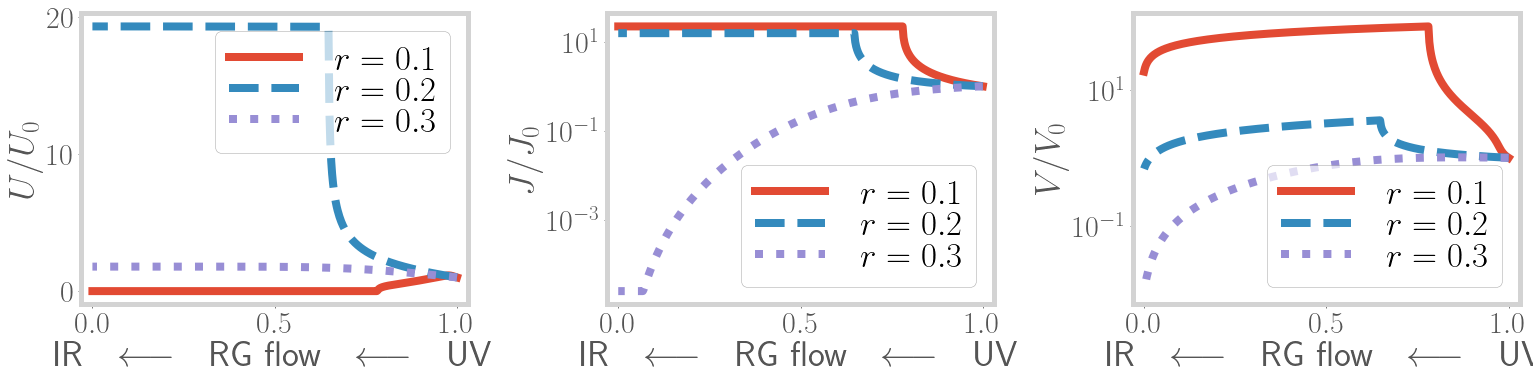

In [122]:
def plot_rgflows_Ub(args):
    D0 = args["D0"]
    w = -D0/2
    V0 = D0 * args["V0_by_D0"]
    J0 = V0 * args["J0_by_V0"]
    Ub_range = J0 * args["Ub_range"]
    # Ub_range = -(J0/4) * np.array([0.3, 0.8, 1.1])
    fig, ax = plt.subplots(1,3,figsize=(22,6))
    for i,ylabel in enumerate([r"$U/U_0$", r"$J/J_0$", r"$V/V_0$"]):
        for j,Ub in enumerate(Ub_range):
            U0 = -Ub * 100
            E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=Ub)
            V[V < 1e-4] = 1e-4
            J[J < 1e-4] = 1e-4
            steps = E/D0
            y_arr = [U,J,V][i] / [U[0], J[0], V[0]][i]
            label = r"$r={:.1f}$".format(-Ub/J0)
            ax[i].plot(steps, y_arr, label=label, ls=linestyles[j])
        ax[i].legend(handlelength=2)
        if i > 0: ax[i].set_yscale("log")
        # ax[i].set_yscale("log")
        ax[i].set_ylabel(ylabel)
        ax[i].set_xlabel(r"IR ~ $\longleftarrow$ ~ RG flow ~ $\longleftarrow$ ~ UV")
        
    plt.savefig(fig_save_path + "rg-flows-all.pdf", bbox_inches='tight')
    plt.show()


plot_rgflows_Ub({"D0": 20,
                 "V0_by_D0": 0.1,
                 "J0_by_V0": 2,
                 "Ub_range": -0.25 * np.array([0.3, 0.8, 1.2])})

## **PHASE DIAGRAM OF THE e-SIAM**
<hr style="border:2px solid skyblue">

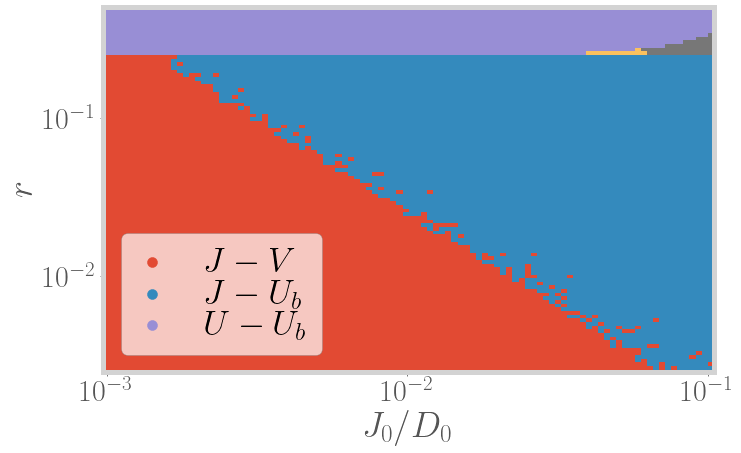

In [165]:
def get_phasemap(args):
    D0 = args["D0"]
    w = -D0/2
    num_points = args["num_points"]
    J0_lims = args["J0_lims"]
    J0_range = (D0) * 10**np.linspace(J0_lims[0], J0_lims[1], num_points)
    # J0_range = (D0) * np.linspace(J0_lims[0], J0_lims[1], num_points)
    r_lims = args["r_lims"]
    r_log10_range = np.linspace(r_lims[0], r_lims[1], num_points)
    try:
        # raise ValueError()
        results = np.load(spectrum_path_phases(D0,num_points,J0_lims[0],J0_lims[1],
                                               r_lims[0],r_lims[1],args["V_by_J"],args["U_by_Ub"]))
    except:
        sub_args = [(D0, args["V_by_J"] * J0, J0, -(J0/4) * 10**r_log10, -args["U_by_Ub"] * (-J0/4) * 10**r_log10, x, y)
                    for (x, J0), (y, r_log10) in product(enumerate(J0_range), enumerate(r_log10_range))]
        results = list(tqdm(Pool().imap(get_fixed_point_type, sub_args), total=len(sub_args)))
        np.save(spectrum_path_phases(D0,num_points,J0_lims[0],J0_lims[1],
                                     r_lims[0],r_lims[1],args["V_by_J"],args["U_by_Ub"]),
                results)

    labels = [r"$J-V$", r"$J-U_b$", r"$U-U_b$", ""]
    xdata, ydata, zdata = -np.zeros(num_points), -np.zeros(num_points), -np.zeros((num_points, num_points))
    data2d = -np.ones((num_points, num_points))
    for x, y, fp_type, xi, yi in results:
        zdata[int(yi)][int(xi)] = fp_type
        xdata[int(xi)] = x
        ydata[int(yi)] = y
    assert -1 not in zdata
    
    cmap = colors.ListedColormap(cols[:int(np.amax(zdata))+1])
    plt.pcolormesh(xdata, ydata, zdata, cmap=cmap).set_edgecolor('face')
    for col, label in zip(cols, labels): plt.scatter([], [], color=col, label=label)
    plt.xlabel(r"$J_0/D_0$")
    plt.ylabel(r"$r$")
    plt.yscale("log")
    plt.xscale("log")
    plt.legend(loc="lower left")
    
    plt.savefig(fig_save_path + "phase-map-MIT.pdf", bbox_inches='tight')
    plt.savefig(fig_save_path + "phase-map-MIT.png", dpi=300, bbox_inches='tight')
    plt.show()

get_phasemap({"D0": 2000,
              "num_points": 100,
              "J0_lims": (-3, -0.99),
              "r_lims": (-2, 0.3),
              "V_by_J": 10,
              "U_by_Ub": 20})

## **EXCITED STATE DESCRIPTORS, ABOUT $U_{c1}$**
<hr style="border:2px solid skyblue">

In [ ]:
def get_excited_corrs(args):
    u,v,j,Ub,t,num_sites = args
    total_dim = 2 * (1 + num_sites)
    Ham_r = get_full_ham(t, num_sites, u, v, j, Ubath=Ub)
    try:
        E = qload(spectrum_path_E(num_sites, t, u, v, j, Ub))
        X = qload(spectrum_path_X(num_sites, t, u, v, j, Ub))
    except:
        E, X = Ham_r.eigenstates()
        qsave(E, spectrum_path_E(num_sites, t, u, v, j, Ub))
        qsave(X, spectrum_path_X(num_sites, t, u, v, j, Ub))
    
    E_lm_mixed_guess = -Ub/2 -(u - Ub)/4 - sqrt(4*v**2 + (u - Ub)**2/4)/2
    E_gap = np.round(E[1:] - E[:-1], 2)
    X_exc_index = list(E_gap).index(E_gap[E_gap == max(E_gap)][0]) + 1
    assert E_lm_mixed_guess > E[X_exc_index]
    X_exc = X[X_exc_index]
    I_di = [get_MI(X_exc,[0,1],[2*i,2*i+1]) for i in range(1,num_sites+1)]
    I_0i = [get_MI(X_exc,[2*i, 2*i+1],[2,3]) for i in range(2, num_sites+1)]
    one_part_0i = [abs(get_1p(X_exc, (1,i))) for i in range(2, num_sites+1)]
    one_part_d0 = abs(get_1p(X_exc, (0,1)))
    spin_flip_corr_0i =  [abs(get_spin_flip_corr(X_exc, (1,i))) for i in range(2, num_sites+1)]
    charge_flip_corr_0i = [abs(get_charge_flip_corr(X_exc, (1,i))) for i in range(2, num_sites+1)]

    return ({"mutinfo_di": I_di,
             "mutinfo_0i": I_0i,
             "1p_0i": one_part_0i,
             "1p_d0": one_part_d0, 
             "spin_flip_0i": spin_flip_corr_0i,
             "charge_flip_0i": charge_flip_corr_0i,
             })


def get_excited_corrs_rc1(args):
    J_star = args["J_star"]
    num_points = args["num_points"]
    t = args["hopping"]
    num_sites = args["num_sites"]
    U_star_range = args["U_star"] * np.linspace(8, 10, num_points*6)
    V_star_range = J_star * np.linspace(args["V_by_J"], 0, num_points*5)
    V_star_range = np.array(list(V_star_range) + [0]*num_points)
    u_c1 = U_star_range[V_star_range == 0][0]
    results = []
    quants = [0, 0]
    ylabels = [r"$I(d:0)$", r"$I(0:1)$", 
               r"$|\braket{c^\dagger_{0 \uparrow}c_{1  \uparrow}}|$",
               r"$2|\braket{c^\dagger_{d \uparrow}c_{0  \uparrow}}|$", 
               r"$|\frac{1}{2}\braket{S_0^+ S_1^- + \text{h.c.}}|$",
               r"$|\frac{1}{2}\braket{C_0^+ C_1^- + \text{h.c.}}|$",
               r"$\frac{1}{2}\braket{S_0^+ S_2^- + \text{h.c.}}$",
               r"$-\frac{1}{2}\braket{C_0^+ C_2^- + \text{h.c.}}$",
               r"$\frac{1}{2}\braket{S_0^+ S_3^- + \text{h.c.}}$",
               r"$-\frac{1}{2}\braket{C_0^+ C_3^- + \text{h.c.}}$",
               r"$4 I(d:1)$",r"$50 I(d:2)$",r"$I(d:3)$",
               r"$|\braket{c^\dagger_{0 \uparrow}c_{2  \uparrow}}|$",
               r"$2|\braket{c^\dagger_{0 \uparrow}c_{3  \uparrow}}|$",
              ]
    for u,v in tqdm(zip(U_star_range, V_star_range), total=len(V_star_range)):
        Ub = -u/10
        quants = get_excited_corrs((u,v,J_star,Ub,t,num_sites))
        results.append(quants)
        
    I_di = [np.array([r["mutinfo_di"][i] for r in results]) for i in range(num_sites)]
    I_0i = [np.array([r["mutinfo_0i"][i] for r in results]) for i in range(num_sites-1)]
    one_p_0i = [np.array([r["1p_0i"][i] for r in results]) for i in range(num_sites-1)]
    one_p_d0 = np.array([r["1p_d0"] for r in results])
    spin_flip_0i = [np.array([r["spin_flip_0i"][i] for r in results]) for i in range(num_sites-1)]
    charge_flip_0i = [np.array([r["charge_flip_0i"][i] for r in results]) for i in range(num_sites-1)]
    
    please_plot(U_star_range/u_c1, [I_di[0], I_0i[0], 4*I_di[1], 50*I_di[2]],
                    [r"$I(d:0)$", r"$I(0:1)$",
                     r"$4 I(d:1)$",r"$50 I(d:2)$"],
                    r"mutual information",
                    r"$r/r_{c1}$",
                    "Uc1-mutinfo.pdf")
                     
    please_plot(U_star_range/u_c1, [I_0i[0], 2*I_0i[1], 2*I_0i[2]],
                    [r"$I_{01}$",
                     r"$4I_{02}$",
                     r"$4I_{03}$"],
                    r"mutual information",
                    r"$r/r_{c1}$",
                    "Uc1-bath-mutinfo.pdf")
    
    please_plot(U_star_range/u_c1, [one_p_0i[0], 2*one_p_d0, 2*one_p_0i[2]],
                    [r"$|\braket{c^\dagger_{0 \uparrow}c_{1  \uparrow}}|$",
                     r"$2|\braket{c^\dagger_{d \uparrow}c_{0  \uparrow}}|$",
                     r"$2|\braket{c^\dagger_{0 \uparrow}c_{3  \uparrow}}|$"],
                    r"1-particle correlations",
                    r"$r/r_{c1}$",
                    "Uc1-1p.pdf")
    
    please_plot(U_star_range/u_c1, [spin_flip_0i[0], charge_flip_0i[0]],
                    [r"$|\frac{1}{2}\braket{S_0^+ S_1^- + \text{h.c.}}|$",
                     r"$|\frac{1}{2}\braket{C_0^+ C_1^- + \text{h.c.}}|$"],
                    r"spin/charge correlations",
                    r"$r/r_{c1}$",
                    "Uc1-spin-charge-01.pdf")
    
    please_plot(U_star_range/u_c1, [spin_flip_0i[1], charge_flip_0i[1]],
                    [r"$|\frac{1}{2}\braket{S_0^+ S_2^- + \text{h.c.}}|$",
                     r"$|\frac{1}{2}\braket{C_0^+ C_2^- + \text{h.c.}}|$"],
                    r"spin/charge correlations",
                    r"$r/r_{c1}$",
                    "Uc1-spin-charge-02.pdf")
    
    please_plot(U_star_range/u_c1, [spin_flip_0i[2], charge_flip_0i[2]],
                    [r"$|\frac{1}{2}\braket{S_0^+ S_3^- + \text{h.c.}}|$",
                     r"$|\frac{1}{2}\braket{C_0^+ C_3^- + \text{h.c.}}|$"],
                    r"spin/charge correlations",
                    r"$r/r_{c1}$",
                    "Uc1-spin-charge-03.pdf")

    

get_excited_corrs_rc1({"J_star": 50, 
                      "num_points": 7, 
                      "U_star": 0.1,
                      "V_by_J": 0.1, 
                      "hopping": 1, 
                      "num_sites": 4})


## **GROUND-STATE DESCRIPTORS, OVER FULL RANGE**
<hr style="border:2px solid skyblue">

In [ ]:
def get_correlations_over_range(args):
    D0, t, num_sites, (Ub_min, Ub_max), num_points = args["D_0"], args["hop"], args["num_sites"], args["Ub_lims"], args["num_points"]
    J0 = D0 * args["J_by_D"]
    V0 = J0 * args["V_by_J"]
    U_by_Ub = args["U_by_Ub"]
    computables = args["computables"]
    momentum_sets = [[]]
    w = -D0/2
    Ub_range = -(J0/4)*np.linspace(Ub_min, Ub_max, num_points)
    x_vals = -Ub_range/J0
    
    non_inter_args = {"couplings": (w,D0,V0,J0,U_by_Ub), "sys_params": (t, num_sites, momentum_sets)}
    args = [(Ub, non_inter_args, computables) for Ub in Ub_range]
    num_threads = 40 if num_sites < 5 else 2

    results = list(tqdm(Pool(num_threads).imap(get_gstate_correlations, args), total=num_points))
    
    r_c1                = [x for x, r in zip(x_vals, results) if r["V_c1"] <= 1][0]
    SS                  = [r["SS_weight"] for r in results]
    CT                  = [r["CT_weight"] for r in results]
    LM                  = [r["LM_weight"] for r in results]
    xi_SS               = [r["geo_ent_ss"] for r in results]
    xi_CT               = [r["geo_ent_ct"] for r in results]
    QFI_spin            = [r["QFI_spinflip"] for r in results]
    QFI_charge          = [r["QFI_charge"] for r in results]
    QFI_Sdz             = [r["QFI_Sdz"] for r in results]
    spin_flip_corr_di   = [[r["spinflip_corr_di"][i] for r in results] 
                           for i,e in enumerate(results[0]["spinflip_corr_di"])]
    charge_flip_corr_di = [[r["chargeflip_corr_di"][i] for r in results] 
                           for i,e in enumerate(results[0]["chargeflip_corr_di"])]
    S_imp               = [r["S_EE"] for r in results]
    I_di                = [[r["mutinfo_di"][i] for r in results] 
                           for i,e in enumerate(results[0]["mutinfo_di"])]
    doub_occ    = [[r["doub_occ"][i] for r in results] 
                           for i,e in enumerate(results[0]["doub_occ"])]
        
    please_plot(x_vals, [LM, SS, CT],
                    [r"$|\braket{\text{LM}|\Psi_\text{gs}}|$",
                     r"$|\braket{\text{SS}|\Psi_\text{gs}}|$",
                     r"$|\braket{\text{CT}|\Psi_\text{gs}}|$"],
                    r"ground-state overlaps", r"$r$",
                    "corrs_gs.pdf")
    
    
    please_plot(x_vals, [xi_CT, xi_SS],
                    [r"$\varepsilon_\text{ct}$",
                     r"$\varepsilon_\text{ss}$"],
                    r"geometric entanglement", r"$r$",
                    "entanglement.pdf")
    
    
    please_plot(x_vals, [QFI_spin, QFI_Sdz, QFI_charge],
                    [r"$\hat O=S_d^+S_0^- + \text{h.c.}$",
                     r"$\hat O=S_d^z$",
                     r"$\hat O=C_0^+ C_1^- + \text{h.c.}$"],
                    r"$F_Q(\Psi_\text{gs}, \hat O)$", r"$r$",
                    "QFI.pdf")
    
    
    please_plot(x_vals, [-np.real(spin_flip_corr_di)[1], np.real(charge_flip_corr_di)[1]],
                    [r"$-\frac{1}{2}\braket{S_{\vec r + \vec a}^+ S_{\vec r}^- + \text{h.c.}}$",
                     r"$\frac{1}{2}\braket{C_{\vec r + \vec a}^+ C_{\vec r}^- + \text{h.c.}}$"],
                    r"spin/charge correlations", r"$r$",
                    "spin-charge-corr-full.pdf")
    
    
    please_plot(x_vals, [S_imp, I_di[0]],
                    [r"$S_\text{EE}(\vec r)$", r"$I_2(\vec r:\vec r+\vec a)$"],
                    r"mutual information", r"$r$",
                    "impEE-mutinfo-d0.pdf")

    
    please_plot(x_vals, [np.real(doub_occ)[0], np.real(doub_occ)[1]],
                    [r"$\braket{\hat n_{d \uparrow}\hat n_{d \downarrow}}$",
                     r"$\braket{\hat n_{0 \uparrow}\hat n_{0 \downarrow}}$"],
                r"imp/bath double occupancy", r"$r$",
                    "doub_occ.pdf")

args = {"D_0": 90,
        "hop": 1,
        "J_by_D": 1/1000,
        "V_by_J": 200,
        "U_by_Ub": 20,
        "Ub_lims": (0.1, 1.1),
        "num_sites": 4,
        "num_points": 80,
        "dimensions": 2,
        "computables": ["V_c1", "SS_weight", "CT_weight", "LM_weight", "geo_ent_ss", "geo_ent_ct", "QFI_spinflip", "QFI_charge", "QFI_Sdz",
                        "spinflip_corr_di", "chargeflip_corr_di", "S_EE", "mutinfo_di", "doub_occ", "density_corr_00",]
}

get_correlations_over_range(args)

## **MOMENTUM SPACE CORRELATIONS, OVER FULL RANGE**
<hr style="border:2px solid skyblue">

In [ ]:
def get_correlations_over_kyrange(args):
    D0, t, num_sites, (Ub_min, Ub_max), num_points, num_slices, num_kpoints = args["D_0"], args["hop"], args["num_sites"], args["Ub_lims"], args["num_points"], args["num_slices"], args["num_kpoints"]
    assert num_slices / 2 == int(num_slices / 2)
    J0 = D0 * args["J_by_D"]
    V0 = J0 * args["V_by_J"]
    U_by_Ub = args["U_by_Ub"]
    computables = args["computables"]
    momentum_sets = get_kpoints(num_slices, num_kpoints, (0, 1))
        
    w = -D0/2
    Ub_range = -(J0/4)*np.linspace(Ub_min, Ub_max, num_points)
    x_vals = -Ub_range/J0
    
    non_inter_args = {"couplings": (w,D0,V0,J0,U_by_Ub), "sys_params": (t, num_sites, momentum_sets)}
    args = [(Ub, non_inter_args, computables) for Ub in Ub_range]
    num_threads = 40 if num_sites < 5 else 2

    results = list(tqdm(Pool(num_threads).imap(get_gstate_correlations, args), total=num_points))
    
    spin_spin_kspace     = np.abs([[r["spin_spin_kspace"][i] for r in results[::-1]] for i,_ in enumerate(momentum_sets)])
    charge_charge_kspace = np.abs([[r["charge_charge_kspace"][i] for r in results[::-1]] for i,_ in enumerate(momentum_sets)])
    charge_flip_kspace   = np.abs([[r["charge_flip_kspace"][i] for r in results[::-1]] for i,_ in enumerate(momentum_sets)])

    titles = [r"$|\braket{\vec S_{-\vec k}\cdot\vec S_{\vec k}}|$", r"$|\braket{\vec C_{-\vec k}\cdot\vec C_{\vec k}}|$",
               r"$|\braket{c^\dagger_{-\vec k \uparrow}c^\dagger_{-\vec k \downarrow}c_{\vec k \downarrow}c_{\vec k \uparrow}}|$",]
    savenames = ["spin", "charge", "pair"]
    for i,corr in enumerate([spin_spin_kspace, charge_charge_kspace, charge_flip_kspace]):
        vmax = np.amax(corr)
        vmin = np.amin(corr)
        required_indices = [0, 2, 3, 5]
        ax_ind = -1
        fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(26, 5), gridspec_kw = {'wspace':0.3, 'hspace':0})
        for j,momentum_set in enumerate(momentum_sets):
            if j not in required_indices: continue
            ax_ind += 1
            im = ax[ax_ind].imshow(corr[j], aspect="auto", cmap=mpl.colormaps["cet_bkr"], extent = (min(momentum_set[0])/np.pi, max(momentum_set[0])/np.pi, Ub_min, Ub_max),
                              vmax=vmax, vmin=vmin, interpolation='none')
            ax[ax_ind].set_xlabel(r"$ak_x/\pi$", size=30)
            ax[ax_ind].set_ylabel(r"$r/r_c$", size=30)
            ax[ax_ind].set_title(titles[i] + r"$,~ \frac{{ak_y}}{{\pi}} = {:.1f}$".format(momentum_set[1][0]/np.pi), size=28)
            ax[ax_ind].tick_params(axis='both', which='major', labelsize=25)
        cbar_ax = fig.add_axes([0.91, 0.13, 0.015, 0.75])
        fig.colorbar(im, cax=cbar_ax)
        plt.savefig("{}_kspace_all.pdf".format(savenames[i]), bbox_inches='tight')
        plt.show()
        
        fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 11), gridspec_kw = {'wspace':0.3, 'hspace':0.5})
        for j,momentum_set in enumerate(momentum_sets):
            row = int(j/3)
            col = j % 3
            im = ax[row][col].imshow(corr[j], aspect="auto", cmap=mpl.colormaps["cet_bkr"], extent = (min(momentum_set[0])/np.pi, max(momentum_set[0])/np.pi, Ub_min, Ub_max),
                              vmax=vmax, vmin=vmin, interpolation='none')
            ax[row][col].set_xlabel(r"$ak_x/\pi$", size=30)
            ax[row][col].set_ylabel(r"$r/r_c$", size=30)
            ax[row][col].set_title(titles[i] + r"$,~ \frac{{ak_y}}{{\pi}} = {:.1f}$".format(momentum_set[1][0]/np.pi), size=28)
            ax[row][col].tick_params(axis='both', which='major', labelsize=25)
        cbar_ax = fig.add_axes([0.93, 0.12, 0.015, 0.76])
        fig.colorbar(im, cax=cbar_ax)
        plt.savefig("{}_kspace_sixpoints.pdf".format(savenames[i]), bbox_inches='tight')
        plt.show()

args_kyrange = {"D_0": 90,
        "hop": 1,
        "J_by_D": 1/1000,
        "V_by_J": 200,
        "U_by_Ub": 20,
        "Ub_lims": (0.1, 1.1),
        "num_sites": 4,
        "num_points": 400,
        "num_slices": 6,
        "num_kpoints": 100,
        "dimensions": 2,
        "computables": ["spin_spin_kspace", "charge_charge_kspace", "charge_flip_kspace"]
}

get_correlations_over_kyrange(args_kyrange)

In [ ]:
def get_correlations_over_rbyrcrange(args):
    D0, t, num_sites, num_kpoints = args["D_0"], args["hop"], args["num_sites"], args["num_kpoints"]
    J0 = D0 * args["J_by_D"]
    V0 = J0 * args["V_by_J"]
    U_by_Ub = args["U_by_Ub"]
    Ub_points = args["Ub_points"]
    computables = args["computables"]
    momentum_sets = get_kpoints(num_kpoints, num_kpoints, (1, 0))
        
    w = -D0/2
    Ub_range = -(J0/4) * np.array(Ub_points)
    
    non_inter_args = {"couplings": (w,D0,V0,J0,U_by_Ub), "sys_params": (t, num_sites, momentum_sets)}
    args = [(Ub, non_inter_args, computables) for Ub in Ub_range]
    num_threads = 40 if num_sites < 5 else 2

    results = list(tqdm(Pool(num_threads).imap(get_gstate_correlations, args), total=len(Ub_range)))
    
    spin_spin_rspace     = np.abs([r["spin_spin_kspace"] for r in results])
    charge_charge_rspace = np.abs([r["charge_charge_kspace"] for r in results])
    charge_flip_rspace   = np.abs([r["charge_flip_kspace"] for r in results])

    titles = [r"$|\braket{\vec S_{-\vec k}\cdot\vec S_{\vec k}}|$", r"$|\braket{\vec C_{-\vec k}\cdot\vec C_{\vec k}}|$",
               r"$|\braket{c^\dagger_{-\vec k \uparrow}c^\dagger_{-\vec k \downarrow}c_{\vec k \downarrow}c_{\vec k \uparrow}}|$",]
    savenames = ["spin", "charge", "pair"]
    for i,corr in enumerate([spin_spin_rspace, charge_charge_rspace, charge_flip_rspace]):
        vmax = np.amax(corr)
        vmin = np.amin(corr)
        
        fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(26, 5), gridspec_kw = {'wspace':0.3, 'hspace':0})
        for j,r_by_rc in enumerate(-4 * Ub_range/J0):
            im = ax[j].imshow(corr[j], aspect="auto", cmap=mpl.colormaps["cet_bkr"], extent = (0, 1, 0, 1),
                              vmax=vmax, vmin=vmin, interpolation='none')
            ax[j].set_xlabel(r"$ak_x/\pi$", size=30)
            ax[j].set_ylabel(r"$ak_y/\pi$", size=30)
            ax[j].set_title(titles[i] + r"$,~ \frac{{r}}{{r_c}} = {:.2f}$".format(r_by_rc), size=28)
            ax[j].tick_params(axis='both', which='major', labelsize=25)
        cbar_ax = fig.add_axes([0.93, 0.12, 0.015, 0.76])
        fig.colorbar(im, cax=cbar_ax)
        plt.savefig("{}_rspace_all.pdf".format(savenames[i]), bbox_inches='tight')
        plt.show()

args_rbyrcrange = {"D_0": 90,
        "hop": 1,
        "J_by_D": 1/1000,
        "V_by_J": 200,
        "U_by_Ub": 20,
        "Ub_points": [0.5, 0.7, 0.9, 0.999],
        "num_sites": 4,
        "num_kpoints": 100,
        "dimensions": 2,
        "computables": ["spin_spin_kspace", "charge_charge_kspace", "charge_flip_kspace"]
}

get_correlations_over_rbyrcrange(args_rbyrcrange)

# **MOMENTUM-SPACE CORRELATION VIDEO**
<hr style="border:2px solid skyblue">

In [ ]:
def save_plot(args):
    j, corr_j, momentum_set, (extent, vlims, dir_name, title) = args
    save_address = dir_name + "/" + "corr_{}.png".format(j)
    plt.imshow(corr_j, aspect="auto", cmap=mpl.colormaps["cet_bkr"], extent = extent,
               vmax=vlims[1], vmin=vlims[0], interpolation='none')
    plt.gcf().set_size_inches(9, 7)
    plt.colorbar()
    plt.xlabel(r"$a|\vec k|/\pi$")
    plt.ylabel(r"$r/r_c$")
    ax_title = r"$\quad a k_y\pi = {:.2f}$".format(momentum_set[1][0]/np.pi)
    plt.title(title + ax_title)
    plt.savefig(save_address, bbox_inches='tight', dpi=300)
    plt.close()
    return "file " + save_address


def get_correlation_video_kspace(args):
    D0, t, num_sites, (Ub_min, Ub_max), num_points, num_kpoints = args["D_0"], args["hop"], args["num_sites"], args["Ub_lims"], args["num_points"], args["num_kpoints"]
    J0 = D0 * args["J_by_D"]
    V0 = J0 * args["V_by_J"]
    U_by_Ub = args["U_by_Ub"]
    computables = args["computables"]
    video_frames = args["video_frames"]
    title = args["title"]
    savename = args["savename"]
    momentum_sets = get_kpoints(video_frames, num_kpoints, (0, 1))

    w = -D0/2
    Ub_range = -(J0/4)*np.linspace(Ub_min, Ub_max, num_points)
    x_vals = -Ub_range/J0
    
    non_inter_args = {"couplings": (w,D0,V0,J0,U_by_Ub), "sys_params": (t, num_sites, momentum_sets)}
    args = [(Ub, non_inter_args, computables) for Ub in Ub_range]
    num_threads = 40 if num_sites < 5 else 2
    results = list(tqdm(Pool(num_threads).imap(get_gstate_correlations, args), total=num_points))
    
    corr = np.abs([[r[computables[0]][i] for r in results[::-1]] for i,_ in enumerate(momentum_sets)])

    vmax = np.amax(corr)
    vmin = np.amin(corr)
    
    dir_name = "movie_plots"
    os.makedirs(dir_name, exist_ok=True)
    for filename in os.listdir(dir_name):
        file_path = os.path.join(dir_name, filename)
        os.unlink(file_path)

    args = zip(range(video_frames), corr, momentum_sets, [[(0, 1, Ub_min, Ub_max), (vmin, vmax), dir_name, title]] * video_frames)
    tries = 0
    while tries < 4:
        try:
            filenames = list(tqdm(Pool().imap(save_plot, args), total=video_frames))
            filedata = list(intersperse("duration 0.04", filenames)) + ["duration 0.04"]
            open("files_list", "w").write("\n".join(filedata))
            cmd = ["ffmpeg", "-f", "concat", "-i", "files_list", "-y", "-hide_banner", "-loglevel", "error", "-vf",
                   "fps=24,scale=480:-1:flags=lanczos,split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse", "-loop", "0", savename]
            subprocess.Popen(cmd).wait()
        except:
            tries += 1
        else:
            tries = 4
        finally:
            if os.path.isdir(dir_name): shutil.rmtree(dir_name)
            if os.path.isfile("files_list"): os.unlink("files_list")


args1 = {"D_0": 90,
        "hop": 1,
        "J_by_D": 1/1000,
        "V_by_J": 200,
        "U_by_Ub": 20,
        "Ub_lims": (0.1, 1.1),
        "num_sites": 4,
        "num_points": 200,
        "num_kpoints": 200,
        "dimensions": 2,
        "video_frames": 200,
        "title": r"$|\braket{\vec S_{-\vec k}\cdot\vec S_{\vec k}}|$",
        "savename": "ss_kspace.gif",
        "computables": ["spin_spin_kspace"],
}
args2 = {"D_0": 90,
        "hop": 1,
        "J_by_D": 1/1000,
        "V_by_J": 200,
        "U_by_Ub": 20,
        "Ub_lims": (0.1, 1.1),
        "num_sites": 4,
        "num_points": 200,
        "num_kpoints": 200,
        "dimensions": 2,
        "video_frames": 200,
        "title": r"$|\braket{c^\dagger_{-\vec k \uparrow}c^\dagger_{-\vec k \downarrow}c_{\vec k \downarrow}c_{\vec k \uparrow}}|$",
        "savename": "pairing_kspace.gif",
        "computables": ["charge_flip_kspace"],
}

get_correlation_video_kspace(args1)
get_correlation_video_kspace(args2)

## **PARAMETER-SPACE CORRELATION VIDEO**
<hr style="border:2px solid skyblue">

In [12]:
def save_plot_rspace(args):
    j, parameter_j, corr_j, (extent, vlims, dir_name, title) = args
    save_address = dir_name + "/" + "corr_{}.png".format(j)
    plt.imshow(corr_j, aspect="auto", cmap=mpl.colormaps["cet_bkr"], extent = extent,
               vmax=vlims[1], vmin=vlims[0], interpolation='none')
    plt.gcf().set_size_inches(9, 7)
    plt.colorbar()
    plt.xlabel(r"$a|\vec k_x|/\pi$")
    plt.ylabel(r"$a|\vec k_y|/\pi$")
    ax_title = r"$\quad r/r_c={:.2f}$".format(parameter_j) if parameter_j < 0.99 else r"$\quad r/r_c={:.3f}$".format(parameter_j)
    plt.title(title + ax_title)
    plt.savefig(save_address, bbox_inches='tight', dpi=300)
    plt.close()
    return "file " + save_address


def get_correlation_video_parameter_space(args):
    D0, t, num_sites, (Ub_min, Ub_max), num_points, k_slices, num_kpoints = args["D_0"], args["hop"], args["num_sites"], args["Ub_lims"], args["num_points"], args["k_slices"], args["num_kpoints"]
    J0 = D0 * args["J_by_D"]
    V0 = J0 * args["V_by_J"]
    U_by_Ub = args["U_by_Ub"]
    computables = args["computables"]
    title = args["title"]
    savename = args["savename"]
    momentum_sets = get_kpoints(k_slices, num_kpoints, (1, 0))
    w = -D0/2
    Ub_range = -(J0/4)*np.linspace(Ub_min, Ub_max, num_points)
    non_inter_args = {"couplings": (w,D0,V0,J0,U_by_Ub), "sys_params": (t, num_sites, momentum_sets)}
    args = [(Ub, non_inter_args, computables) for Ub in Ub_range]
    num_threads = 40 if num_sites < 5 else 2
    results = list(tqdm(Pool(num_threads).imap(get_gstate_correlations, args), total=num_points))
    
    corr = np.abs([r[computables[0]] for r in results])

    vmax = np.amax(corr)
    vmin = np.amin(corr)
    
    dir_name = "movie_plots"
    os.makedirs(dir_name, exist_ok=True)
    for filename in os.listdir(dir_name):
        file_path = os.path.join(dir_name, filename)
        os.unlink(file_path)
    args = zip(range(num_points), - 4 * Ub_range / J0, corr, [[(0, 1, 0, 1), (vmin, vmax), dir_name, title]] * num_points)
    tries = 0
    while tries < 4:
        try:
            filenames = list(tqdm(Pool().imap(save_plot_rspace, args), total=num_points))
            filedata = []
            for name, r_by_rc in zip(filenames, -4 * Ub_range/J0):
                filedata.append(name)
                if r_by_rc > 0.99:
                    filedata.append("duration 2")
                else:
                    filedata.append("duration 0.02")
            open("files_list", "w").write("\n".join(filedata))
            cmd = ["ffmpeg", "-f", "concat", "-i", "files_list", "-y", "-hide_banner", "-loglevel", "error", "-vf",
                   "fps=24,scale=480:-1:flags=lanczos,split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse", "-loop", "0", savename]
            subprocess.Popen(cmd).wait()
        except:
            tries += 1
        else:
            tries = 4
    

args1 = {"D_0": 90,
        "hop": 1,
        "J_by_D": 1/1000,
        "V_by_J": 200,
        "U_by_Ub": 20,
        "Ub_lims": (0.2, 1.01),
        "num_sites": 4,
        "num_points": 300,
        "dimensions": 2,
        "k_slices": 200,
        "num_kpoints": 200,
        "title": r"$|\braket{\vec S_{-\vec k}\cdot\vec S_{\vec k}}|$",
        "savename": "ss_rspace.gif",
        "computables": ["spin_spin_kspace"],
}


args2 = {"D_0": 90,
        "hop": 1,
        "J_by_D": 1/1000,
        "V_by_J": 200,
        "U_by_Ub": 20,
        "Ub_lims": (0.2, 1.01),
        "num_sites": 4,
        "num_points": 300,
        "dimensions": 2,
        "k_slices": 200,
        "num_kpoints": 200,
        "title": r"$|\braket{c^\dagger_{-\vec k \uparrow}c^\dagger_{-\vec k \downarrow}c_{\vec k \downarrow}c_{\vec k \uparrow}}|$",
        "savename": "pairing_rspace.gif",
        "computables": ["charge_flip_kspace"],
}


get_correlation_video_parameter_space(args1)
# get_correlation_video_parameter_space(args2)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

## **MOMENTUM-SPACE ENTANGLEMENT VIDEO**
<hr style="border:2px solid skyblue">

In [ ]:
def save_plot_ent(args):
    j, corr_j, title_end, (extent, vlims, dir_name, title, savename, ylabel) = args
    save_address = dir_name + "/" + savename + "_{}.png".format(j)
    plt.imshow(corr_j, cmap=mpl.colormaps["cet_bkr"], extent = extent,
               vmax=vlims[1], vmin=vlims[0], interpolation='none', aspect='auto')
    plt.gcf().set_size_inches(9, 7)
    plt.colorbar()
    plt.xlabel(r"$ak_x/\pi$")
    # print (title + title_end)
    plt.title(title + title_end)
    plt.ylabel(ylabel)
    plt.savefig(save_address, bbox_inches='tight', dpi=300)
    plt.close()
    return "file " + save_address


def get_ent_video_kspace(args):
    D0, t = args["D_0"], args["hop"]
    w = -D0/2
    J0 = D0 * args["J_by_D"]
    V0 = J0 * args["V_by_J"]
    U_by_Ub = args["U_by_Ub"]
    r_by_rc_vals = np.linspace(args["r_by_rc_min"], args["r_by_rc_max"], args["num_r_by_rc"])
    Ub_vals = - 0.25 * J0 * r_by_rc_vals
    num_sites = args["num_sites"]
    kx_arr = np.linspace(0, np.pi, args["num_kx"])
    ky_arr = np.linspace(0, np.pi, args["num_ky"])
    k2_factor = args["k2_factor"]
    titles = args["titles"]
    savenames = args["savenames"]
    num_threads = args["num_threads"]
    indexof = lambda x, arr: np.argmin(np.abs(x-arr))
    
    Ub_ky_kx_args = product(Ub_vals, ky_arr, kx_arr)
    num_args = len(Ub_vals) * len(kx_arr) * len(ky_arr)
    args_new = list(zip(Ub_ky_kx_args, [[w,D0,V0,J0,U_by_Ub,t,num_sites,k2_factor]]*num_args))
    results = list(tqdm(Pool(num_threads).imap(get_kspace_entanglement_per_val, args_new), total=num_args)) if num_threads > 0 \
              else list(tqdm(Pool().imap(get_kspace_entanglement_per_val, args_new), total=num_args))
    entropyvn_kxkymap = [[[] for _ in ky_arr] for _ in Ub_vals]
    mutualinfo_kxkymap = [[[] for _ in ky_arr] for _ in Ub_vals]
    entropyvn_kxUbmap = [[[] for _ in Ub_vals] for _ in ky_arr]
    mutualinfo_kxUbmap = [[[] for _ in Ub_vals] for _ in ky_arr]
    
    for arg,r in zip(args_new, results):
        Ub, ky, kx = arg[0]
        entropyvn_kxkymap[indexof(Ub, Ub_vals)][-indexof(ky, ky_arr) - 1].append(r[0])
        mutualinfo_kxkymap[indexof(Ub, Ub_vals)][-indexof(ky, ky_arr) - 1].append(r[1])
        entropyvn_kxUbmap[indexof(ky, ky_arr)][-indexof(Ub, Ub_vals) - 1].append(r[0])
        mutualinfo_kxUbmap[indexof(ky, ky_arr)][-indexof(Ub, Ub_vals) - 1].append(r[1])
    
    
    fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(25, 5), gridspec_kw = {'wspace':0.3, 'hspace':0})
    correlations_for_staticframes = [entropyvn_kxUbmap[0], entropyvn_kxUbmap[50], mutualinfo_kxkymap[60], mutualinfo_kxkymap[82]]
    extent_arr = [[0, 1, min(r_by_rc_vals), max(r_by_rc_vals)], [0, 1, min(r_by_rc_vals), max(r_by_rc_vals)], [0, 1, 0, 1], [0, 1, 0, 1]]
    vmax = np.amax(correlations_for_staticframes)
    vmin = np.amin(correlations_for_staticframes)
    for j,corr in enumerate(correlations_for_staticframes):
        im = ax[j].imshow(corr, aspect="auto", cmap=mpl.colormaps["cet_bkr"], extent = extent_arr[j],
                          vmax=vmax, vmin=vmin, interpolation='none')
        ax[j].set_xlabel(r"$ak_x/\pi$", size=30)
        if j < 2:            
            ax[j].set_ylabel(r"$r/r_c$", size=30)
            ax[j].set_title(titles[j] + r"$,~ ak_y/\pi = {:.1f}$".format(ky_arr[[0, 50][j]]/np.pi), size=28)
        else:
            ax[j].set_ylabel(r"$ak_y/\pi$", size=30)
            ax[j].set_title(titles[j] + r"$,~ r/r_c = {:.1f}$".format(r_by_rc_vals[[60, 82][j-2]]), size=28)
        ax[j].tick_params(axis='both', which='major', labelsize=25)
    cbar_ax = fig.add_axes([0.91, 0.13, 0.015, 0.75])
    fig.colorbar(im, cax=cbar_ax)
    plt.savefig("vne_kspace_all.pdf", bbox_inches='tight')
    plt.show()
    
    dir_name = "movie_plots"
    os.makedirs(dir_name, exist_ok=True)
    for filename in os.listdir(dir_name):
        file_path = os.path.join(dir_name, filename)
        os.unlink(file_path)
    extent_arr = [[0, 1, 0, 1], [0, 1, min(r_by_rc_vals), max(r_by_rc_vals)], [0, 1, 0, 1], [0, 1, min(r_by_rc_vals), max(r_by_rc_vals)]]
    ylabel_arr = [r"$a k_y/\pi$", r"$r/r_c$", r"$a k_y/\pi$", r"$r/r_c$"]
    processes = []
    for i,corr in enumerate([entropyvn_kxkymap, entropyvn_kxUbmap, mutualinfo_kxkymap, mutualinfo_kxUbmap]):
        vmax = np.amax(corr)
        vmin = np.amin(corr)
        title_end = [r"$\quad a k_y\pi = {:.2f}$".format(ky/np.pi) for ky in ky_arr] if i % 2 == 1 else [r"$\quad r/r_c={:.2f}$".format(r_by_rc) for r_by_rc in r_by_rc_vals]
        assert len(title_end) == len(corr)
        args = zip(range(len(corr)), corr, title_end, [[extent_arr[i], (vmin, vmax), dir_name, titles[i], savenames[i], ylabel_arr[i]]] * len(corr))
        filenames = list(tqdm(Pool().imap(save_plot_ent, args), total=len(corr)))
        if i in (1,3):
            filedata = list(intersperse("duration 0.1", filenames)) + ["duration 0.1"]
        else:
            filedata = []
            for name, r_by_rc in zip(filenames, r_by_rc_vals):
                filedata.append(name)
                if r_by_rc <= 0.97:
                    filedata.append("duration 0.1")
                elif r_by_rc <= 1.03:
                    filedata.append("duration 0.5")
                else:
                    filedata.append("duration 0")
        _ = open("files_list_{:.0f}".format(i), "w").write("\n".join(filedata))
        cmd = ["ffmpeg", "-f", "concat", "-i", "files_list_{:.0f}".format(i), "-y", "-hide_banner", "-loglevel", "error", "-vf",
               "fps=24,scale=480:-1:flags=lanczos,split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse", "-loop", "0", savenames[i] + ".gif"]
        processes.append(subprocess.Popen(cmd))    
    [proc.wait() for proc in processes]
    [os.unlink("files_list_{:.0f}".format(i)) for i in range(4)]

args_entanglement = {"D_0": 90,
        "hop": 1,
        "J_by_D": 1/1000,
        "V_by_J": 200,
        "U_by_Ub": 20,
        "r_by_rc_min": 0.5,
        "r_by_rc_max": 1.1,
        "dimensions": 2,
        "num_sites": 3,
        "num_kx": 100,
        "num_ky": 100,
        "k2_factor": -1,
        "num_r_by_rc": 100,
        "num_threads": 100,
        "titles": [r"$S_\text{EE}(\vec k)$", r"$S_\text{EE}(\vec k)$", r"$I_2(\vec k: -\vec k)$", r"$I_2(\vec k: -\vec k)$"],
        "savenames": ["entropy_vn_kxkymap", "entropy_vn_kxUbmap", "mutinfo_kxkymap", "mutinfo_kxUbmap"],
}

get_ent_video_kspace(args_entanglement)

## **GROUND-STATE DESCRIPTORS, NEAR $r_{c2}$**
<hr style="border:2px solid skyblue">

In [ ]:
def get_correlations_near_transition(args):
    D0, t, num_sites, (Ub_min, Ub_max), num_points = args["D_0"], args["hop"], args["num_sites"], args["Ub_lims"], args["num_points"]
    J0 = D0 * args["J_by_D"]
    V0 = J0 * args["V_by_J"]
    U_by_Ub = args["U_by_Ub"]
    computables = args["computables"]
    k_vals_node = np.linspace(0, np.pi/2, 500)
    k_vals_node = np.linspace(0, np.pi, 500)
    momenta = [[k_vals_node, k_vals_node], [k_vals_node, np.zeros_like(k_vals_node)]]
    w = -D0/2
    Ub_range = (-J0/4) * (1 - 10**np.linspace(Ub_min, Ub_max, num_points))
    x_vals = 1/(0.25 - (- Ub_range/J0))
    
    non_inter_args = {"couplings": (w,D0,V0,J0,U_by_Ub), "sys_params": (t, num_sites, momenta)}
    args = [(Ub, non_inter_args, computables) for Ub in Ub_range]
    num_threads = 40 if num_sites < 5 else 2

    results = list(tqdm(Pool(num_threads).imap(get_gstate_correlations, args), total=num_points))
    
    chargeflip_corr_0i = [np.array([r["chargeflip_corr_0i"][i] for r in results]) for i in range(num_sites)]
    spinflip_corr_di = [np.array([r["spinflip_corr_di"][i] for r in results]) for i in range(num_sites+1)]
    I_0i = [np.array([r["mutinfo_0i"][i] for r in results]) for i in range(num_sites-1)]
    I_di = [np.array([r["mutinfo_di"][i] for r in results]) for i in range(num_sites)]
    I_d01 = np.array([r["tripinfo_d01"] for r in results])
    spin_spin_corr_di = [np.array([r["spin_spin_corr_di"][i] for r in results]) for i in range(num_sites+1)]
    charge_ising_corr_0i = [np.array([r["charge_ising_corr_0i"][i] for r in results]) for i in range(num_sites)]
    spin_ising_corr_di = [np.array([r["spin_ising_corr_di"][i] for r in results]) for i in range(num_sites+1)]
    charge_charge_corr_0i = [np.array([r["charge_charge_corr_0i"][i] for r in results]) for i in range(num_sites)]
    density_corr_00 = np.array([r["density_corr_00"] for r in results])
    imp_EE = np.array([r["S_EE"] for r in results])
    QFI_sf = np.array([r["QFI_spinflip"] for r in results])
    QFI_ch = np.array([r["QFI_charge"] for r in results])
    QFI_sd = np.array([r["QFI_Sdz"] for r in results])
           
    please_plot(x_vals, 
                    (chargeflip_corr_0i[1], -spinflip_corr_di[1]),
                    [r"$\braket{C_0^+ C_1^-}$",
                     r"$-\braket{S_d^+ S_0^-}$"],
                    r"spin/charge correlations",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-spin-charge-corr.pdf",
                    logx=True)    

    # plot spin-flip correlations - d i, i > 0
    please_plot(x_vals, 
                    (5*np.abs(spinflip_corr_di[2]),
                     np.abs(spinflip_corr_di[3]),
                     30*np.abs(spinflip_corr_di[4]),
                     np.abs(spinflip_corr_di[5]),),
                    [r"$5|\braket{S_d^+ S_1^-}|$",
                     r"$|\braket{S_d^+ S_2^-}|$",
                     r"$30|\braket{S_d^+ S_3^-}|$",
                     r"$|\braket{S_d^+ S_4^-}|$"],
                    r"spin/charge correlations",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-spin-flip-di.pdf",
                    logx=True)   


    # plot mutual/trip. info - d1 & d01
    please_plot(x_vals, (I_0i[0], I_di[0], 500*I_di[1], 5*I_d01),
                    [r"$I_2(0:1)$", r"$I_2(d:0)$",
                     r"$500 I_2(d:1)$", r"$5 I_3(d:0:1)$"],
                    r"mutual/tripartite information",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-mut-trip-info.pdf",
                    logx=True)       



    # plot mutual info 0i
    please_plot(x_vals, 
                    (I_0i[0],
                     3*I_0i[1],
                     5*I_0i[2],
                     5*I_0i[3]),
                    [r"$I_2(0:1)$",
                     r"$3I_2(0:2)$",
                     r"$5I_2(0:3)$",
                     r"$5I_2(0:4)$",],
                    r"bath mutual information",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-mut-info-bath.pdf",
                    logx=True)  


    # plot spin-spin correlation - d0
    please_plot(x_vals, 
                    (spin_spin_corr_di[1], 3*spin_ising_corr_di[1]),
                    [r"$\braket{\vec S_d \cdot \vec S_0}$",
                     r"$3\braket{S_d^z S_0^z}$"],
                    r"spin correlations: $d-0$",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-spin-corr-d0.pdf",
                    logx=True)  


    # plot spin-spin correlations - di
    please_plot(x_vals, 
                    (5*np.abs(spin_spin_corr_di[2]),
                     np.abs(spin_spin_corr_di[3]),
                     20*np.abs(spin_spin_corr_di[4]),
                     np.abs(spin_spin_corr_di[5]),),
                    [r"$5|\braket{{\vec S_d \cdot \vec S_1}}|$",
                     r"$|\braket{{\vec S_d \cdot \vec S_2}}|$",
                     r"$20|\braket{{\vec S_d \cdot \vec S_3}}|$",
                     r"$|\braket{{\vec S_d \cdot \vec S_4}}|$"],
                    r"imp.-bath spin correlations",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-spinspin-corr-di.pdf",
                    logx=True) 


    # plot charge-flip correlations - 0i
    please_plot(x_vals, 
                    (np.abs(chargeflip_corr_0i[1]),
                     3*np.abs(chargeflip_corr_0i[2]),
                     10*np.abs(chargeflip_corr_0i[3]),
                     4*np.abs(chargeflip_corr_0i[4]),),
                    [r"$|\braket{C_0^+ C_1^-}|$",
                     r"$3|\braket{C_0^+ C_2^-}|$",
                     r"$10|\braket{C_0^+ C_3^-}|$",
                     r"$4|\braket{C_0^+ C_4^-}|$"],
                    r"bath charge correlations",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-charge-flip-corr-0i.pdf",
                    logx=True)


    # plot charge-ising correlations - 0i
    please_plot(x_vals, 
                    (charge_ising_corr_0i[1],
                     3*charge_ising_corr_0i[2],
                     10*charge_ising_corr_0i[3],
                     3*charge_ising_corr_0i[4],),
                    [r"$\braket{C_0^z C_1^z}$",
                     r"$3\braket{C_0^z C_2^z}$",
                     r"$10\braket{C_0^z C_3^z}$",
                     r"$3\braket{C_0^z C_4^z}$"],
                    r"bath CDW correlations",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-charge-ising-corr-0i.pdf",
                    logx=True)


    # plot spin-ising correlations - di
    please_plot(x_vals, 
                    (5*np.abs(spin_ising_corr_di[2]),
                     np.abs(spin_ising_corr_di[3]),
                     20*np.abs(spin_ising_corr_di[4]),
                     np.abs(spin_ising_corr_di[5]),),
                    [r"$5|\braket{S_d^z S_1^z}|$",
                     r"$|\braket{S_d^z S_2^z}|$",
                     r"$20|\braket{S_d^z S_3^z}|$",
                     r"$|\braket{S_d^z S_4^z}|$"],
                    r"Ising correlations",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-spin-ising-corr-di.pdf",
                    logx=True)


    # plot charge-charge correlations - 0i
    please_plot(x_vals, 
                    (np.abs(charge_charge_corr_0i[1]),
                     np.abs(charge_charge_corr_0i[2]),
                     10*np.abs(charge_charge_corr_0i[3]),
                     np.abs(charge_charge_corr_0i[4]),),
                    [r"$|\braket{{\vec C_0 \cdot \vec C_1}}|$",
                     r"$|\braket{{\vec C_0 \cdot \vec C_2}}|$",
                     r"$10|\braket{{\vec C_0 \cdot \vec C_3}}|$",
                     r"$|\braket{{\vec C_0 \cdot \vec C_4}}|$"],
                    r"bath charge correlations",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-charge-charge-corr-0i.pdf",
                    logx=True)

    # plot QFI
    please_plot(x_vals, 
                    (0.9 * QFI_sf, QFI_sd, QFI_ch),
                    [r"$\hat O=S_d^+S_0^- + \text{h.c.}$",
                     r"$\hat O=S_d^z$",
                     r"$\hat O=C_0^+ C_1^- + \text{h.c.}$"],
                    r"$F_Q(\Psi_\text{gs}, \hat O)$",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-QFI.pdf",
                    logx=True)
    
    spin_spin_kspace     = [r["spin_spin_kspace"] for r in results]
    charge_charge_kspace = [r["charge_charge_kspace"] for r in results]
    charge_flip_kspace = [r["charge_flip_kspace"] for r in results]
    titles = [r"$\braket{\vec S(-\vec k)\cdot\vec S(\vec k)}$", r"$\braket{\vec C(-\vec k)\cdot\vec C(\vec k)}$",
              r"$\braket{c^\dagger(\vec k,\uparrow)c^\dagger(\vec k,\downarrow)c(-\vec k,\downarrow)c(-\vec k,\uparrow)}$"]
    for i,corr in enumerate([spin_spin_kspace, charge_charge_kspace, charge_flip_kspace]):
        plt.imshow(np.real(corr), aspect="auto", cmap="coolwarm", extent = (0, np.pi/2, max(x_vals), min(x_vals)), interpolation='none')
        plt.colorbar()
        plt.suptitle(titles[i], y=0.9)
        plt.xlabel(r"$k_x = k_y$")
        plt.ylabel(r"$1/(r - r_c)$")
        plt.yscale("log")
        plt.savefig("corr_rc2_{}.pdf".format(i), bbox_inches='tight')
        plt.show()

    
    
args = {"D_0": 100,
        "hop": 0.01,
        "J_by_D": 1e-4,
        "V_by_J": 0,
        "U_by_Ub": 0,
        "Ub_lims": (-0.75, -3),
        "num_sites": 5,
        "num_points": 40,
        "dimensions": 2,
        "computables": ["chargeflip_corr_0i", "spinflip_corr_di", "mutinfo_0i", "mutinfo_di", "tripinfo_d01",
                        "spin_spin_corr_di", "charge_ising corr_0i", "spin_ising_corr_di", "charge_ising_corr_0i",
                        "charge_charge_corr_0i", "density_corr_00", "S_EE", "QFI_spinflip", "QFI_charge", "QFI_Sdz",
                        "spin_spin_kspace", "charge_charge_kspace", "charge_flip_kspace"]
}
get_correlations_near_transition(args)

## **GROUND-STATE DESCRIPTORS, *ABOUT* $r_{c2}$**
<hr style="border:2px solid skyblue">

In [ ]:
def get_correlations_across_transition(args):
    t = args["hopping"]
    D0 = args["bandwidth"]
    J0_by_D0 = args["J_by_bwidth"]
    num_points = args["num_points"]
    num_sites = args["num_sites"]
    save_fig = args["save_fig"]
    J0 = D0 * J0_by_D0
    Ub_lims = args["Ub_lims"]
    computables = args["computables"]
    k_vals = np.linspace(0, np.pi/2, 500)
    momenta = [k_vals, k_vals]
    
    Ub_range = -0.25 * J0 * (1 + np.linspace(Ub_lims[0], Ub_lims[1], num_points))
    args = product([(num_sites, t, D0, J0, computables, momenta)], Ub_range)
    results = list(tqdm(Pool().imap(get_gstate_correlations_J_Ub, args), total=len(Ub_range)))
    x_arr = -Ub_range/J0
    charge_flip_corr_0i = [np.array([r["charge_flip_corr_0i"][i] for r in results])
                           for i in range(num_sites-1)]
    I_0i = [np.array([r["mutinfo_0i"][i] for r in results])
            for i in range(num_sites-1)]
    I_di = [np.array([r["mutinfo_di"][i] for r in results])
            for i in range(num_sites)]
    I_d01 = np.array([r["tripinfo_d01"] for r in results])

    please_plot(x_arr, charge_flip_corr_0i[0],
                    [],
                    r"$\frac{1}{2}\braket{{C_0^+ C_1^- + \text{h.c.}}}$",
                    r"$r$",
                    "charge-flip-01-across.pdf",
                    )
  
    
    please_plot(x_arr, [I_di[0], I_0i[0]],
                    [r"$I_2(d:0)$",
                    r"$I_2(0:1)$"],
                    r"imp. \& bath mutual info.",
                    r"$r$",
                    "mut-info-d0-01-across.pdf",
                    )
    
    
    please_plot(x_arr, [I_di[1], I_d01],
                    [r"$I_2(d:1)$", r"$I_3(d:0:1)$"],
                    "Mut. \& tripartite info.",
                    r"$r$",
                    "trip-info-across.pdf",
                    )


get_correlations_across_transition({"hopping": 0.01, 
                                    "bandwidth": 100,
                                    "J_by_bwidth": 10**(-3.75), 
                                    "Ub_lims": (-0.004, 0.001), 
                                    "num_points": 30,
                                    "num_sites": 4,
                                    "save_fig": False,
                                    "computables": ["charge_flip_corr_0i", "spin_flip_corr_di", "mutinfo_0i", "mutinfo_di", "tripinfo_d01",
                                                    "spin_spin_corr_di", "charge_flip_corr_0i", "charge_ising_corr_0i",
                                                    "spin_ising_corr_di", "charge_charge_corr_0i", "S_EE",]
                                   })

In [ ]:
def get_correlations_across_transition(args):
    t = args["hopping"]
    D0 = args["bandwidth"]
    J0_by_D0 = args["J_by_bwidth"]
    num_points = args["num_points"]
    num_sites = args["num_sites"]
    save_fig = args["save_fig"]
    J0 = D0 * J0_by_D0
    Ub_lims = args["Ub_lims"]
    computables = args["computables"]
    k_vals = np.linspace(0, np.pi/2, 500)
    # momenta = np.meshgrid(k_vals, np.flip(k_vals))
    momenta = [k_vals, k_vals]
    
    Ub_range = (-J0/4) * (1 - 10**np.linspace(Ub_lims[0], Ub_lims[1], num_points))
    args = product([(num_sites, t, D0, J0, computables, momenta)], Ub_range)
    results = list(tqdm(Pool().imap(get_gstate_correlations_J_Ub, args), total=len(Ub_range)))
    x_arr = 1/(0.25 + Ub_range/J0)

    spin_spin_kspace     = [r["spin_spin_kspace"] for r in results]
    charge_charge_kspace = [r["charge_charge_kspace"] for r in results]
    charge_flip_kspace = [r["charge_flip_kspace"] for r in results]
    titles = [r"$\braket{\vec S(-\vec k)\cdot\vec S(\vec k)}$", r"$\braket{\vec C(-\vec k)\cdot\vec C(\vec k)}$",
              r"$\braket{c^\dagger(\vec k,\uparrow)c^\dagger(\vec k,\downarrow)c(-\vec k,\downarrow)c(-\vec k,\uparrow)}$"]
    for i,corr in enumerate([spin_spin_kspace, charge_charge_kspace, charge_flip_kspace]):
        plt.imshow(np.real(corr), aspect="auto", cmap="coolwarm", extent = (0, np.pi/2, max(x_arr), min(x_arr)), interpolation='none')
        plt.colorbar()
        plt.suptitle(titles[i], y=0.9)
        plt.xlabel(r"$k_x = k_y$")
        plt.ylabel(r"$1/(r - r_c)$")
        plt.yscale("log")
        plt.savefig("corr_rc2_{}.pdf".format(i), bbox_inches='tight')
        plt.show()


get_correlations_across_transition({"hopping": 0.04, 
                                    "bandwidth": 10,
                                    "J_by_bwidth": 10**(-3), 
                                    "Ub_lims": (-0.7, -2.5), 
                                    "num_points": 200,
                                    "num_sites": 4,
                                    "save_fig": False,
                                    "computables": ["spin_spin_kspace", "charge_charge_kspace", "charge_flip_kspace"]
                                   })

## **BEHAVIOUR OF THE IMPURITY SPECTRAL FUNCTION**
<hr style="border:2px solid skyblue">

In [ ]:
def plot_spec_func(args):
    D0 = args["D0"]
    V0 = args["V0"]
    J0 = args["J0"]
    Ub_by_J_arr = args["Ub_by_J_arr"]
    broad_guess_arr = args["broad_guess_arr"]
    num_sites = args["num_sites"]
    num_points = args["num_points"]
    eta_delta = args["eta_delta"]
    use_guess = args["use_guess"]
    omega_disp_max = args["omega_disp_max"]
    ops = args["ops"]
    plot = args["plot"] 
    
    spec_func_list = []
    
    target_height = 1
    for i, (Ub_by_J, broad_guess) in enumerate(zip(Ub_by_J_arr, broad_guess_arr)):
        J0_eff = J0 if Ub_by_J > 0 else 0
        Ub = -J0 * Ub_by_J
        U0 = -20 * Ub
        print ("U0 =", U0)
        label = r"$r={:.2f}r_c$".format(4*Ub_by_J)
        _, omega_arr, spec_func_norm = full_spec_func(V0, J0, U0, D0, Ub, num_points, num_sites, target_height, broad_guess, eta_delta, use_guess, ops)
        if U0 == 0 and Ub == 0:
            target_height = spec_func_norm[omega_arr >= 0][0]
        if plot: plt.plot(omega_arr[abs(omega_arr) < omega_disp_max], spec_func_norm[abs(omega_arr) < omega_disp_max], label=label, lw=4, color=cols[i%5])
        spec_func_list.append([omega_arr, spec_func_norm, label])
        print ("Area =", np.trapz(spec_func_list[-1][1], spec_func_list[-1][0]))
        print ("--------")

    if plot:
        plt.xlabel(r"$\omega$")
        plt.ylabel(r"$A(\omega)$")
        plt.legend(loc="upper right")
        plt.savefig("spectral-function-{}.pdf".format(ops), bbox_inches='tight')
        plt.show()
    return spec_func_list
    

In [ ]:
spec_func_list_dd = plot_spec_func({"D0": 1500, "V0": 0.3, "J0": 0.1, "Ub_by_J_arr": [0, 0.07, 0.09, 0.13, 0.19, 0.21, 0.228, 0.24904, 0.27],
                                    "broad_guess_arr": np.array([0.05, 0.0375249, 0.036867599, 0.0353046, 0.0313551, 0.0292815, 0.02063432, 0.00317250, 0.001]), "num_sites": 2, "num_points": 2001,
                                    "eta_delta": 0.2, "use_guess": False, "no_Ub": False, "omega_disp_max": 0.4, "ops": (0,0), "plot": True})
spec_func_list_d0 = plot_spec_func({"D0": 1500, "V0": 0.3, "J0": 0.1, "Ub_by_J_arr": [0, 0.07, 0.1, 0.13, 0.19, 0.21, 0.228, 0.24904, 0.27],
                                    "broad_guess_arr": np.array([0.05, 0.0375249, 0.03528, 0.0353046, 0.0315118754, 0.0292815, 0.02063432, 0.00317250, 0.001]), "num_sites": 2, "num_points": 2001,
                                    "eta_delta": 0.2, "use_guess": False, "no_Ub": False, "omega_disp_max": 0.4, "ops": (0,1), "plot": True})

In [ ]:
k_points = np.linspace(0, np.pi, 100)
kx, ky = np.meshgrid(k_points, np.flip(k_points))
i = 0
omega_arr = spec_func_list_dd[0][0]
Add_arr = [np.trapz(Add[abs(omega_arr) < 0.125], omega_arr[abs(omega_arr) < 0.125]) for _, Add, _ in spec_func_list_dd]
Ad0_arr = [np.trapz(Ad0[abs(omega_arr) < 0.125], omega_arr[abs(omega_arr) < 0.125]) for _, Ad0, _ in spec_func_list_d0]
A_k_arr = [Add + Ad0 * 2 * (np.cos(kx) + np.cos(ky)) / 4 for Add,Ad0 in zip(Add_arr, Ad0_arr)]
max_A = np.max([np.max(A_k) for A_k in A_k_arr])
min_A = np.min([np.min(A_k) for A_k in A_k_arr])
factors = [0, 0.07, 0.09, 0.13, 0.19, 0.21, 0.228, 0.24904, 0.27]
factors_needed = [0, 0.13, 0.228, 0.27]
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(25, 5), gridspec_kw = {'wspace':0.3, 'hspace':0})
for r_by_rc, A_k in zip(factors, A_k_arr):
    if r_by_rc not in factors_needed: continue
    i += 1
    im = ax[i-1].imshow(A_k, vmin=min_A, vmax=max_A,  aspect='auto', extent=(0, 1, 0, 1,))
    ax[i-1].set_title(r"$A_{{\vec k}}(\omega \sim 0), \quad r/r_c={:.2f}$".format(r_by_rc/0.25), size=28)
    ax[i-1].set_xlabel(r"$ak_x/\pi$", size=25)
    ax[i-1].set_ylabel(r"$ak_y/\pi$", size=25)
    ax[i-1].tick_params(axis='both', which='major', labelsize=25)
cbar_ax = fig.add_axes([0.91, 0.13, 0.015, 0.75])
fig.colorbar(im, cax=cbar_ax)
plt.savefig("kspace-spectral-function-all.pdf", bbox_inches='tight')
plt.show()

## **BEHAVIOUR OF THE LOCAL SELF-ENERGY**
<hr style="border:2px solid skyblue">

In [ ]:
from scipy import signal
from scipy import integrate

sigma_imag = []
i = 0
omega_arr = spec_func_list_dd[0][0]
spec_func_dd_nonint = spec_func_list_dd[0][1]
spec_func_d0_nonint = spec_func_list_d0[0][1]
small_param = 1e-4
factors = [0, 0.07, 0.1, 0.13, 0.19, 0.21, 0.228, 0.24904, 0.27]
omega_arr = spec_func_list_dd[0][0]
for (_,spec_func_dd,_), (_,spec_func_d0,_) in zip(spec_func_list_dd, spec_func_list_d0):
    i += 1
    imag_G_dd = np.round(spec_func_dd, 4)
    imag_G_dd_nonint = np.round(spec_func_dd_nonint, 4)
    real_G_dd = -np.imag(signal.hilbert(imag_G_dd_nonint))
    real_G_dd_nonint = -np.imag(signal.hilbert(imag_G_dd_nonint))
    sigma_dd = 1/(real_G_dd_nonint + 1j * imag_G_dd_nonint + 1j * small_param) - 1/(real_G_dd + 1j * imag_G_dd + 1j * small_param)
    imag_G_d0 = np.round(spec_func_d0, 4)
    imag_G_d0_nonint = np.round(spec_func_d0_nonint, 4)
    real_G_d0 = -np.imag(signal.hilbert(imag_G_d0_nonint))
    real_G_d0_nonint = -np.imag(signal.hilbert(imag_G_d0_nonint))
    sigma_d0 = 1/(real_G_d0_nonint + 1j * imag_G_d0_nonint + 1j * small_param) - 1/(real_G_d0 + 1j * imag_G_d0 + 1j * small_param)
    sigma_imag.append([np.abs(np.imag(sigma_dd)), np.abs(np.imag(sigma_d0))])

## **BEHAVIOUR OF THE MOMENTUM-SPACE SELF-ENERGY**
<hr style="border:2px solid skyblue">

In [ ]:
k_points = np.linspace(0, np.pi, 100)
kx, ky = np.meshgrid(k_points, np.flip(k_points))
omega_arr = spec_func_list_dd[0][0]
Sigma_dd_arr = [np.trapz(sigma_dd[abs(omega_arr) < 0.125], omega_arr[abs(omega_arr) < 0.125]) for sigma_dd, _ in sigma_imag]
Sigma_d0_arr = [np.trapz(sigma_d0[abs(omega_arr) < 0.125], omega_arr[abs(omega_arr) < 0.125]) for _, sigma_d0 in sigma_imag]
Sigma_k_arr = [sigma_dd + sigma_d0 * 2 * (np.cos(kx) + np.cos(ky)) / 4 for sigma_dd, sigma_d0 in zip(Sigma_dd_arr, Sigma_d0_arr)]
max_sigma = np.max([np.max(Sigma_k) for Sigma_k in Sigma_k_arr])
min_sigma = np.min([np.min(Sigma_k) for Sigma_k in Sigma_k_arr])
i = 0
factors = [0, 0.07, 0.09, 0.13, 0.19, 0.21, 0.228, 0.24904, 0.27]
factors_needed = [0, 0.13, 0.228, 0.27]
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(25, 5), gridspec_kw = {'wspace':0.3, 'hspace':0})
for r_by_rc, Sigma_k in zip(factors, Sigma_k_arr):
    if r_by_rc not in factors_needed: continue
    i += 1
    im = ax[i-1].imshow(Sigma_k, vmin=min_sigma, vmax=max_sigma, aspect='auto', extent=(0, 1, 0, 1,))
    ax[i-1].set_title(r"$\text{{Im}}\left[\Sigma_{{\vec k}}\right](\omega \sim 0),~ r/r_c={:.2f}$".format(r_by_rc/0.25), size=25)
    ax[i-1].set_xlabel(r"$ak_x/\pi$", size=25)
    ax[i-1].set_ylabel(r"$ak_y/\pi$", size=25)
    ax[i-1].tick_params(axis='both', which='major', labelsize=25)

cbar_ax = fig.add_axes([0.91, 0.13, 0.015, 0.75])
fig.colorbar(im, cax=cbar_ax)
plt.savefig("kspace-imagsigma-all.pdf", bbox_inches='tight')
plt.show()

## **ZERO-MODE SPECTRUM**
<hr style="border:2px solid skyblue">

In [ ]:
def twosite_spectrum():
    J = 1
    Ub_range1 = np.arange(-0.1, -3*J/2, -0.01)
    Ub_range2 = np.arange(-3*J/2, -2, -0.01)
    Ub_range = np.arange(-0.1, -2, -0.01)

    E_ss = -3*J/4 - Ub_range1/2
    E_st = J/4 - Ub_range1/2
    E_charge = Ub_range * 0
    E_lm_lm = -Ub_range2/2

    plt.rcParams["figure.figsize"] = (11,6)
    plt.plot(-(2/3)*Ub_range1/J, E_ss)
    plt.plot(-(2/3)*Ub_range/J, E_charge)

    plt.annotate(r"$\ket{S=0}$", (0.6,-0.4))
    plt.annotate(r"$\ket{\pm \frac{1}{2}}\otimes\ket{0,2}$", (1.02, -0.1))
    plt.annotate(r"$-\frac{3\mathcal{\tilde J}}{4} - \frac{\mathcal{\tilde U}_b}{2}$", (0.13,-0.25), size=40)
    plt.arrow(0.45, -0.38, 0, 0.32, width=0.008, color="gray")
    plt.arrow(0.45, -0.05, 0, -0.31, width=0.008, color="gray")

    plt.xlabel(r"$-2 \mathcal{\tilde U}_b/3 \mathcal{\tilde J}$")
    plt.ylabel(r"energy eigenvalues")

    plt.savefig(fig_save_path + "twosite_spectrum.pdf", bbox_inches='tight')
    
twosite_spectrum()

## **BULK GROUND-STATE (1D)**
<hr style="border:2px solid skyblue">

In [ ]:
def get_bulk_gstate(args):
    V, [bulk_num_sites, num_sites, U, indices] = args
    J = 0
    U = 1
    Ubath = 0#-U/10
    ham_left = get_ham_rspace(V, num_sites, U, V, J, Ubath=Ubath, reflect=False)
    E, X = ham_left.eigenstates()
    Xgs_left = X[0]
    # print (V, get_MI(Xgs_left, [0,1], [2,3]), get_MI(Xgs_left, [0,1], [4,5]), get_MI(Xgs_left, [0,1], [6,7]))
    ham_right = get_ham_rspace(V, num_sites, U, V, J, Ubath=Ubath)
    E, X = ham_right.eigenstates()
    Xgs_right = X[0]
    unity = tensor([basis(2,0) + basis(2,1)] * 2)
    Xgs_bulk = 0
    for i in range(bulk_num_sites - num_sites):
        Xgs_bulk_left = tensor([unity] * i + [Xgs_left] + [unity] * (bulk_num_sites - num_sites - 1 - i)).unit()
        Xgs_bulk_right = tensor([unity] * (bulk_num_sites - num_sites - 1 - i) + [Xgs_right] + [unity] * i).unit()
        Xgs_bulk += (Xgs_bulk_left + Xgs_bulk_right).unit()
    Xgs_bulk = Xgs_bulk.unit()
    I2_results = [get_MI(Xgs_bulk,[2*i, 2*i + 1],[2*j, 2*j + 1]) for i,j in indices]
    # print (V, I2_results[0])
    return I2_results

V_arr = np.linspace(0, 0.1, 5)
indices = [(1,2)]
args = zip(V_arr, [[4, 2, 10*max(V_arr), indices]] * len(V_arr))
I2_results = list(tqdm(Pool(1).imap(get_bulk_gstate, args), total=len(V_arr)))
# I2_results = Pool(1).imap(get_bulk_gstate, args)
I2_arr = [[I2[i] for I2 in I2_results] for i,_ in enumerate(indices)]
print (np.round(I2_arr[0], 10))
for (i,j), I2 in zip(indices, I2_arr):
    plt.scatter(V_arr, I2, label=r"$I_2({}:{})$".format(i,j))
plt.legend()
plt.xlabel(r"$V/U$")
# for V in tqdm():
#     I2 = get_bulk_gstate(V)
#     plt.scatter(V, I2)
# plt.xscale("log")

In [ ]:
plt.figure(figsize=(8,6))
temp = 10**np.linspace(-5, 0.6, 1000)
resistivity = temp**2 - np.log(temp)
plt.plot(temp, resistivity)
plt.xscale("log")
plt.xlabel(r"temperature(T)")
plt.ylabel(r"$T^n - \ln T$")
plt.savefig("test.pdf", bbox_inches='tight')
plt.show()